**Table of contents**<a id='toc0_'></a>    
- 1. [Models on the 3 RFM features](#toc1_)    
  - 1.1. [Preparing the data + Sampling the dataset for time computation purposes.](#toc1_1_)    
  - 1.2. [t-SNE (finding the right perplexity and hinting the underlying manifold?)](#toc1_2_)    
    - 1.2.1. [On the full dataset sample Xs](#toc1_2_1_)    
    - 1.2.2. [ T-sne restricted to multiple-time buyers.](#toc1_2_2_)    
  - 1.3. [Kmeans](#toc1_3_)    
  - 1.4. [Hierarchical clustering](#toc1_4_)    
  - 1.5. [DBSCAN](#toc1_5_)    
  - 1.6. [OPTICS](#toc1_6_)    
  - 1.7. [Conclusion of the first attempts of clustering.](#toc1_7_)    
- 2. [Clustering with more features.](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import missingno as msno
import seaborn as sns
import project_tools as pt
import data_science_functions as ds

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# from scipy.cluster.hierarchy import dendrogram

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)


In [2]:
# Load clients' info
clients = pd.read_csv('clients_rfm.csv.gz', index_col='customer_unique_id')
clients.rfm_code = clients.rfm_code.fillna(0).astype('int').astype('object')
display(clients.info())
clients.head()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   monetary_value_sum                 96096 non-null  float64
 1   monetary_value_mean_per_order      96096 non-null  float64
 2   total_number_of_purchases          96096 non-null  int64  
 3   number_of_purchases_last_365_days  96096 non-null  int64  
 4   number_of_purchases_last_90_days   96096 non-null  int64  
 5   number_of_purchases_last_30_days   96096 non-null  int64  
 6   elapsed_days_since_last_purchase   96096 non-null  int64  
 7   number_of_items_ordered_max        95420 non-null  float64
 8   number_of_items_ordered_min        95420 non-null  float64
 9   number_of_items_mean_per_order     95420 non-null  float64
 10  review_score_max                   95380 non-null  float64
 11  r

None

monetary_value_sum  \
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2              141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f               27.19   
0000f46a3911fa3c0805444483337064               86.22   
0000f6ccb0745a6a4b88665a16c9f078               43.62   
0004aac84e0df4da2b147fca70cf8255              196.89   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2                         141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f                          27.19   
0000f46a3911fa3c0805444483337064                          86.22   
0000f6ccb0745a6a4b88665a16c9f078                          43.62   
0004aac84e0df4da2b147fca70cf8255                         196.89   

                                  total_number_of_purchases  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                          1   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1   
0000f46a3911fa3c0805444483337064                          1   
0000f6ccb0745a6a4b88665a16c9f078                          1   
0004aac84e0df4da2b147fca70cf8255                          1   

                                  number_of_purchases_last_365_days  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2                                  1   
0000b849f77a49e4a4ce2b2a4ca5be3f                                  1   
0000f46a3911fa3c0805444483337064                                  0   
0000f6ccb0745a6a4b88665a16c9f078                                  0   
0004aac84e0df4da2b147fca70cf8255                                  1   

                                  number_of_purchases_last_90_days  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                                 0   
0000b849f77a49e4a4ce2b2a4ca5be3f                                 0   
0000f46a3911fa3c0805444483337064                                 0   
0000f6ccb0745a6a4b88665a16c9f078                                 0   
0004aac84e0df4da2b147fca70cf8255                                 0   

                                  number_of_purchases_last_30_days  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                                 0   
0000b849f77a49e4a4ce2b2a4ca5be3f                                 0   
0000f46a3911fa3c0805444483337064                                 0   
0000f6ccb0745a6a4b88665a16c9f078                                 0   
0004aac84e0df4da2b147fca70cf8255                                 0   

                                  elapsed_days_since_last_purchase  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                               160   
0000b849f77a49e4a4ce2b2a4ca5be3f                               163   
0000f46a3911fa3c0805444483337064                               585   
0000f6ccb0745a6a4b88665a16c9f078                               369   
0004aac84e0df4da2b147fca70cf8255                               336   

                                  number_of_items_ordered_max  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1.0   
0000f46a3911fa3c0805444483337064                          1.0   
0000f6ccb0745a6a4b88665a16c9f078                          1.0   
0004aac84e0df4da2b147fca70cf8255                          1.0   

                                  number_of_items_ordered_min  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2                          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                          1.0   
0000f46a3911fa3c0805444483337064          

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Clustering Models on the 3 RFM features

## 1.1.  [&#9650;](#toc0_) <a id='toc1_1_'></a>Preparing the data + Sampling the dataset for time computation purposes.

Initially, this section was done only with pre_processor_standard, and then I added pre_processor_robust to see if I could gain improvement changing the pre_processing (over all of the total_number_of_purchases). But it happened to give bad results.

In [3]:
# Pre-processing config.
skewed_fts = ['monetary_value_sum', 'total_number_of_purchases']
fts_to_scale = ['elapsed_days_since_last_purchase']
fts_pass = []
all_fts = [*skewed_fts, *fts_to_scale, *fts_pass]
log_transformer = FunctionTransformer(func=np.log1p)

# Standard scaler
pre_processor_standard = make_column_transformer(
        (make_pipeline(log_transformer, StandardScaler()), skewed_fts),
        (StandardScaler(), fts_to_scale),
        ('passthrough', fts_pass),
)

# Robust scaler
pre_processor_robust = make_column_transformer(
        (make_pipeline(log_transformer, RobustScaler()), skewed_fts),
        (StandardScaler(), fts_to_scale),
        ('passthrough', fts_pass),
)

# Selecting the pre_processor if I use it later.
pre_processor = pre_processor_standard

# Pre-processing
X = clients.dropna(axis=0).copy()

Xpp = pre_processor_standard.fit_transform(X)
Xpp = pd.DataFrame(Xpp,
                   index=X.index,
                   columns=['monetary_value_sum_pp',
                            'total_number_of_purchases_pp',
                            'elapsed_days_since_last_purchase_pp'])

Xppr = pre_processor_robust.fit_transform(X)
Xppr = pd.DataFrame(Xppr,
                   index=X.index,
                   columns=['monetary_value_sum_pp',
                            'total_number_of_purchases_pp',
                            'elapsed_days_since_last_purchase_pp'])


# Sampling for computation time and checking 
# if RFM classes are well represented.
print("proportion of each cluster in the dataset")
display(X.segment.value_counts() * 100 / len(X))


print("proportion of each cluster in the sample")
Xs = X.sample(10_000, random_state=3).copy()
display(Xs.segment.value_counts() * 100 / len(Xs))

print("number of clients in each cluster in the sample")
display(Xs.segment.value_counts())

Xspp = pre_processor_standard.fit_transform(Xs)
Xspp = pd.DataFrame(Xspp,
                    index=Xs.index,
                    columns=['monetary_value_sum_pp',
                             'total_number_of_purchases_pp',
                             'elapsed_days_since_last_purchase_pp'])
Xsppr = pre_processor_robust.fit_transform(Xs)
Xsppr = pd.DataFrame(Xsppr,
                     index=Xs.index,
                     columns=['monetary_value_sum_pp',
                              'total_number_of_purchases_pp',
                              'elapsed_days_since_last_purchase_pp'])

proportion of each cluster in the dataset


old_one_time_buyer_small_value           65.639780
not_so_old_one_time_buyer_small_value    17.674198
Recent_one_time_buyer_small_value         9.326436
old_one_time_buyer_high_value             2.944468
old_multiple_buyer_for_small_value        1.854941
Recent_one_time_buyer_high_value          1.270059
recent_multiple_buyer_for_small_value     0.881546
old_multiple_buyer_for_high_value         0.261824
recent_multiple_buyer_for_high_value      0.146748
Name: segment, dtype: float64

proportion of each cluster in the sample


old_one_time_buyer_small_value           65.30
not_so_old_one_time_buyer_small_value    17.44
Recent_one_time_buyer_small_value         9.83
old_one_time_buyer_high_value             3.19
old_multiple_buyer_for_small_value        1.90
Recent_one_time_buyer_high_value          1.09
recent_multiple_buyer_for_small_value     0.77
old_multiple_buyer_for_high_value         0.29
recent_multiple_buyer_for_high_value      0.19
Name: segment, dtype: float64

number of clients in each cluster in the sample


old_one_time_buyer_small_value           6530
not_so_old_one_time_buyer_small_value    1744
Recent_one_time_buyer_small_value         983
old_one_time_buyer_high_value             319
old_multiple_buyer_for_small_value        190
Recent_one_time_buyer_high_value          109
recent_multiple_buyer_for_small_value      77
old_multiple_buyer_for_high_value          29
recent_multiple_buyer_for_high_value       19
Name: segment, dtype: int64

RAW


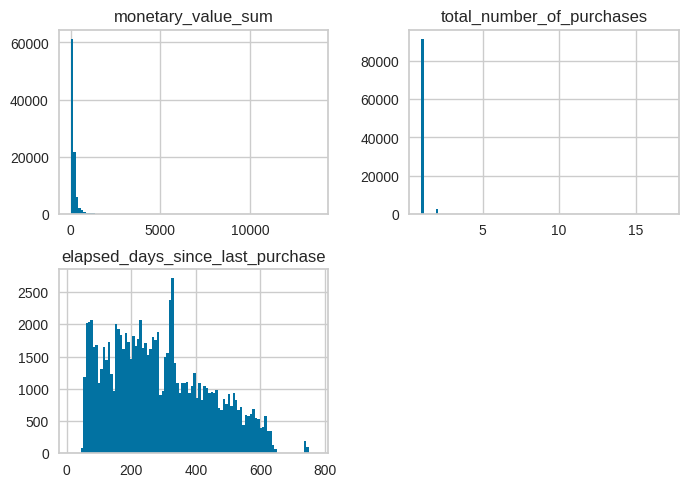

After pp


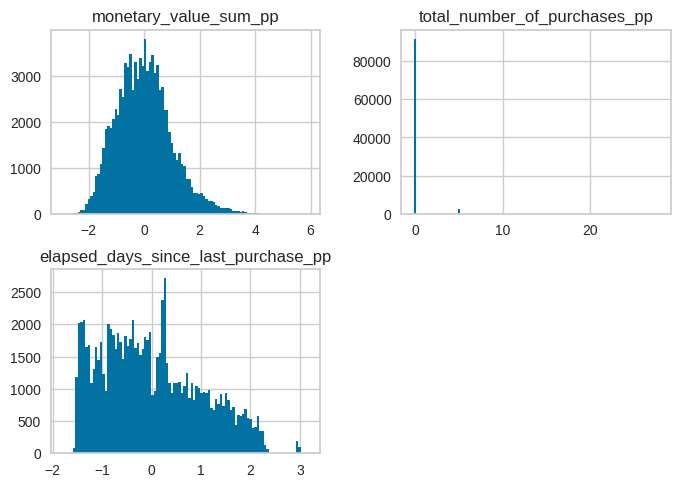

After ppr


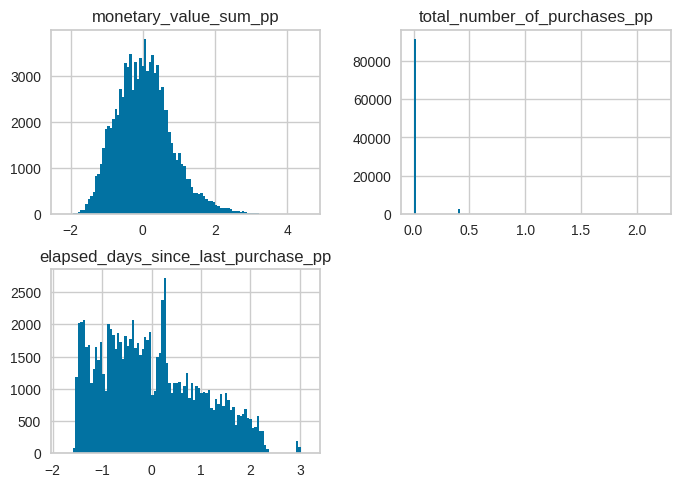

After pp log


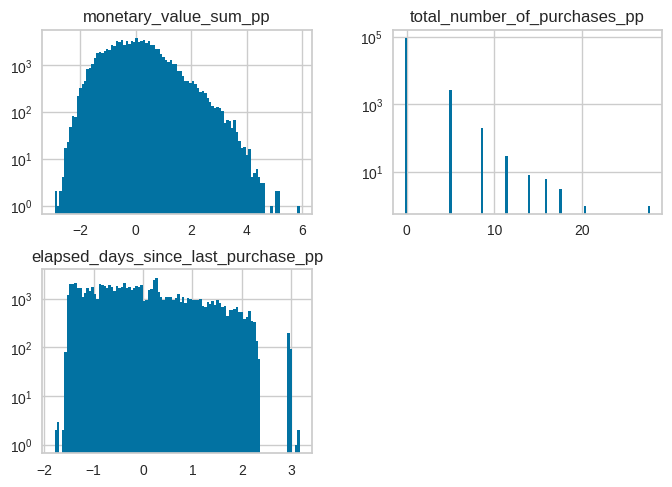

After ppr log


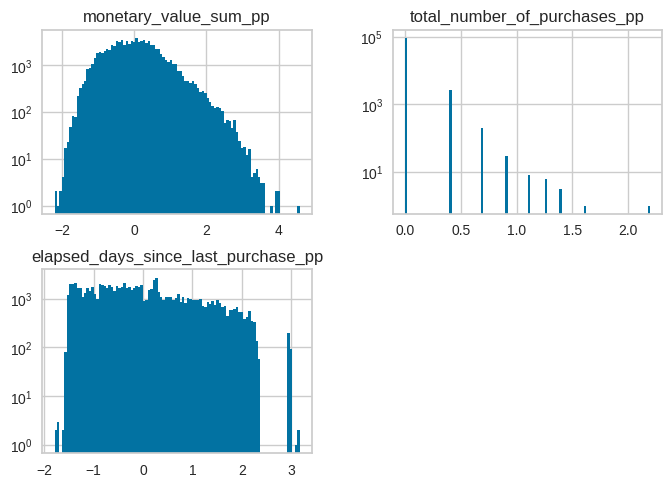

In [11]:
print('RAW')
X[all_fts].hist(bins=100)
plt.show()
print('After pp')
Xpp.hist(bins=100)
plt.show()
print('After ppr')
Xppr.hist(bins=100)
plt.show()
print('After pp log')
Xpp.hist(bins=100, log=True)
plt.show()
print('After ppr log')
Xppr.hist(bins=100, log=True)
plt.show()

In [12]:
Xpp.describe()

monetary_value_sum_pp  total_number_of_purchases_pp  \
count           9.472000e+04                  9.472000e+04   
mean           -1.197691e-15                  2.257954e-16   
std             1.000005e+00                  1.000005e+00   
min            -2.926670e+00                 -1.743264e-01   
25%            -7.042828e-01                 -1.743264e-01   
50%            -5.046502e-02                 -1.743264e-01   
75%             5.968665e-01                 -1.743264e-01   
max             5.914189e+00                  2.777964e+01   

       elapsed_days_since_last_purchase_pp  
count                         9.472000e+04  
mean                          1.075716e-16  
std                           1.000005e+00  
min                          -1.788448e+00  
25%                          -8.091095e-01  
50%                          -1.301012e-01  
75%                           7.121301e-01  
max                           3.167006e+00

In [13]:
Xppr.describe()

monetary_value_sum_pp  total_number_of_purchases_pp  \
count           94720.000000                  94720.000000   
mean                0.038785                      0.013702   
std                 0.768555                      0.078602   
min                -2.210511                      0.000000   
25%                -0.502493                      0.000000   
50%                 0.000000                      0.000000   
75%                 0.497507                      0.000000   
max                 4.584143                      2.197225   

       elapsed_days_since_last_purchase_pp  
count                         9.472000e+04  
mean                          1.075716e-16  
std                           1.000005e+00  
min                          -1.788448e+00  
25%                          -8.091095e-01  
50%                          -1.301012e-01  
75%                           7.121301e-01  
max                           3.167006e+00

array([[<AxesSubplot: title={'center': 'monetary_value_sum_pp'}>,
        <AxesSubplot: title={'center': 'total_number_of_purchases_pp'}>],
       [<AxesSubplot: title={'center': 'elapsed_days_since_last_purchase_pp'}>,
        <AxesSubplot: >]], dtype=object)

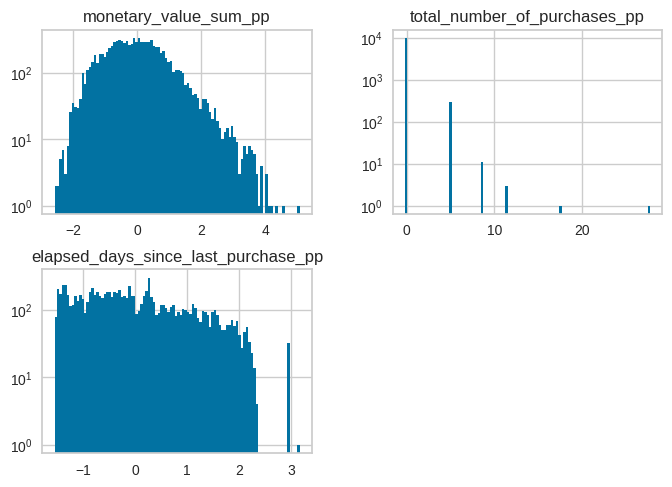

In [14]:
Xspp.hist(bins=100, log=True)

## 1.2.  [&#9650;](#toc0_) <a id='toc1_2_'></a>t-SNE (finding the right perplexity and hinting the underlying manifold?)

### 1.2.1.  [&#9650;](#toc0_) <a id='toc1_2_1_'></a>On the full dataset sample Xs

15
30
50
70
85
100


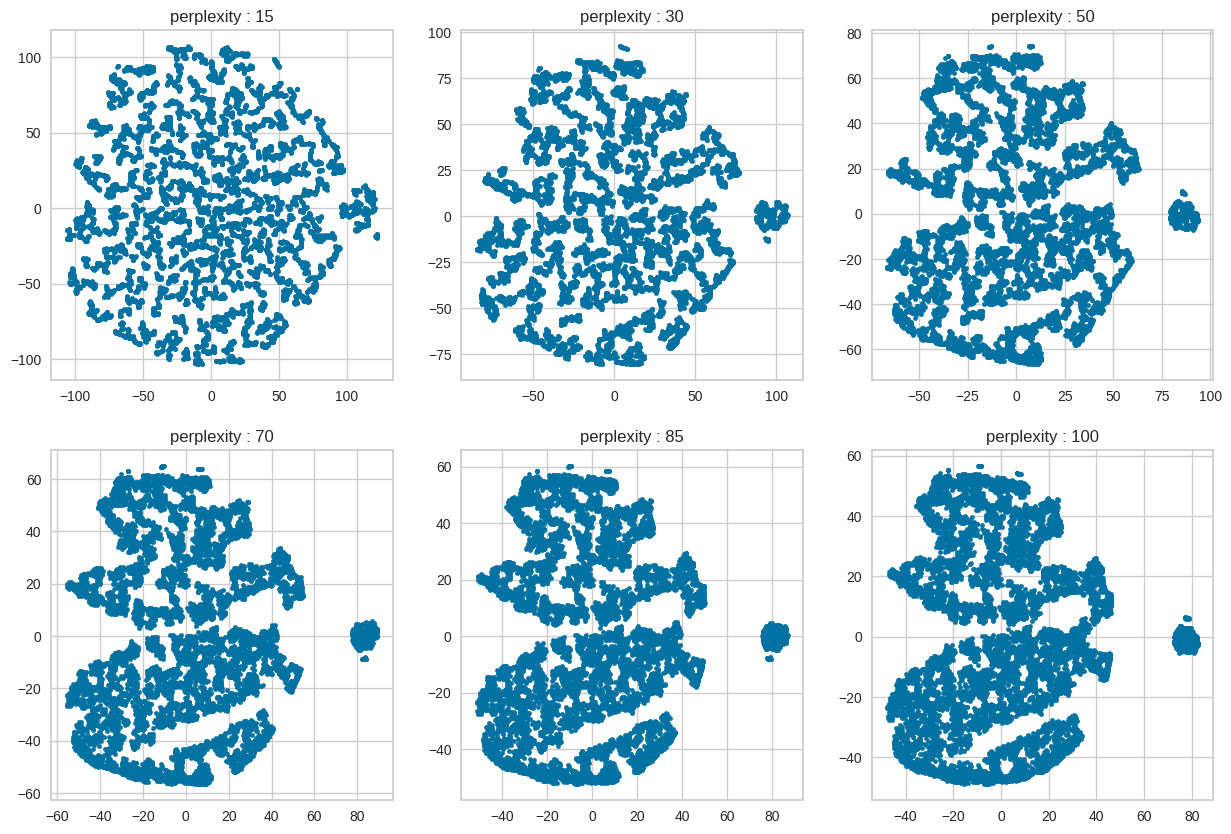

In [15]:
# Plotting results for several perplexities
fig, axes = plt.subplots(2,3, figsize=(15,10))
perplexities = [15, 30, 50, 70, 85, 100]
for perplexity, ax in zip(perplexities, axes.flat):
    print(perplexity)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_jobs=-1)
    Xs_2d = tsne.fit_transform(Xspp)
    ax.scatter(Xs_2d[:, 0], Xs_2d[:, 1], marker='o', s=10)
    ax.set_title(f'perplexity : {perplexity}')
plt.show()    

A nice value for the perplexity here seems to be 85. If what is revealed is correct, we might have 2 main clusters, then one 'denser' cluster, and some very little clusters in margin.

In [16]:
X_embedded = TSNE(n_components=2, perplexity=85, n_jobs=-1).fit_transform(Xspp)
X_embedded = pd.DataFrame(X_embedded,
                          index=Xs.index,
                          columns=['x','y'])
X_embedded['segment'] = Xs.segment

/tmp/ipykernel_21522/3090465470.py:1: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(data=X_embedded, x='x', y='y', hue='segment',


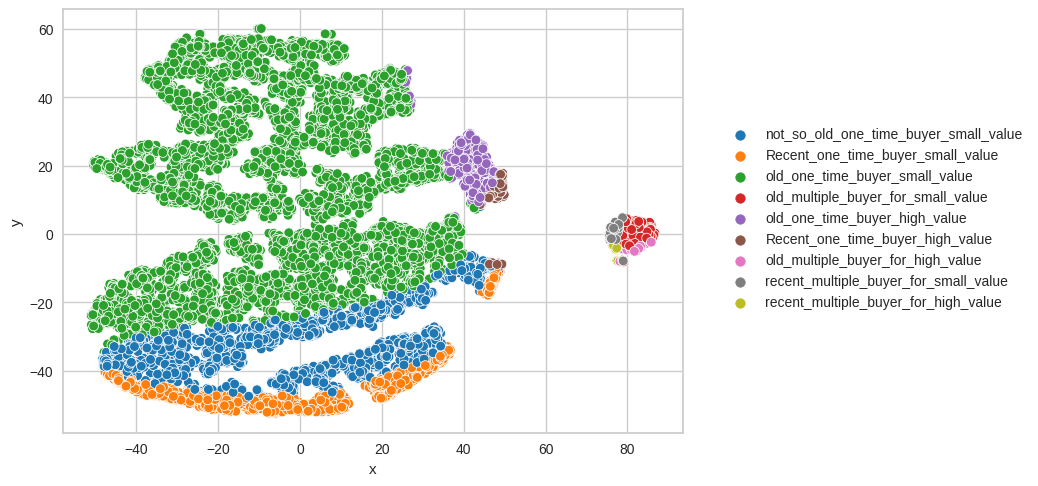

In [17]:
sns.scatterplot(data=X_embedded, x='x', y='y', hue='segment',
                palette=sns.color_palette("tab10"))
plt.legend(bbox_to_anchor=(1.05,0.75))
plt.show()

Indeed, the isolated dense cluster is about multiple-time buyers.

### 1.2.2.  [&#9650;](#toc0_) <a id='toc1_2_2_'></a> T-sne restricted to multiple-time buyers.

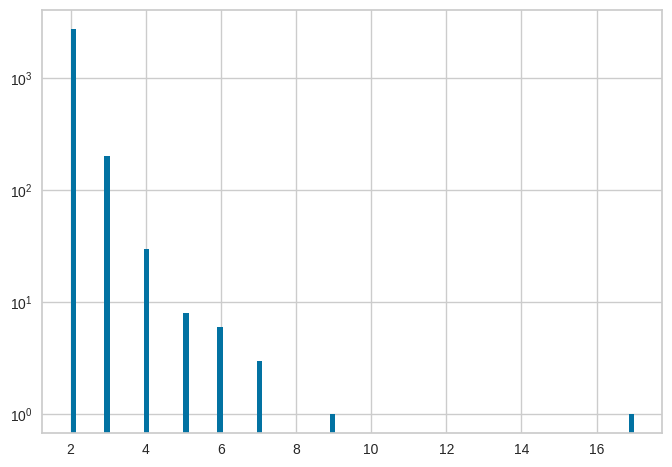

(2997, 3)

In [18]:
raw_X = clients.query('total_number_of_purchases > 1')
raw_X.total_number_of_purchases.hist(bins=100, log=True)
plt.show()
X_mult_pp = pre_processor.fit_transform(raw_X)
X_mult_pp.shape

In [19]:
X_embedded = TSNE(n_components=2, perplexity=85).fit_transform(X_mult_pp)

In [20]:
X_embedded = pd.DataFrame(X_embedded,
                          index=raw_X.index,
                          columns=['x','y'])
X_embedded['segment'] = raw_X.segment

/tmp/ipykernel_21522/3090465470.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=X_embedded, x='x', y='y', hue='segment',


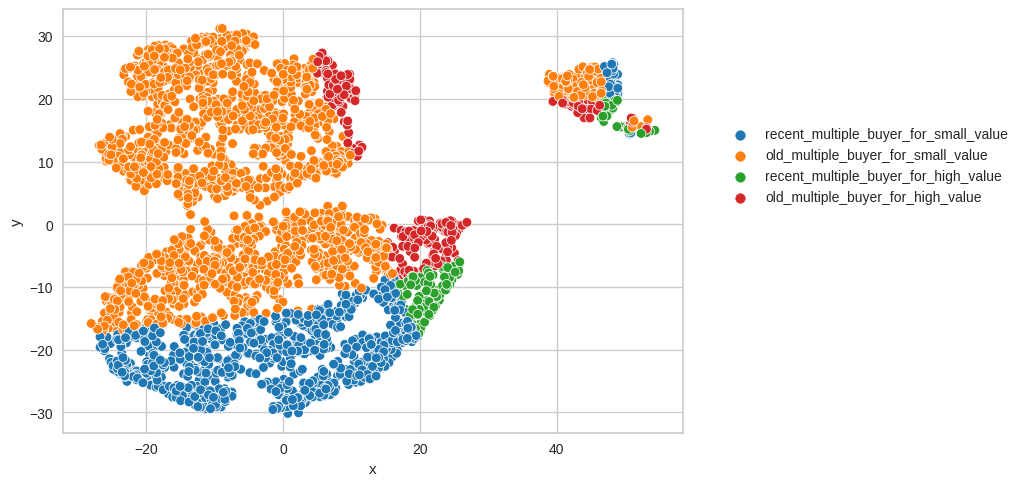

In [21]:
sns.scatterplot(data=X_embedded, x='x', y='y', hue='segment',
                palette=sns.color_palette("tab10"))
plt.legend(bbox_to_anchor=(1.05,0.75))
plt.show()

In [22]:
X_embedded.iloc[:, :2]

x          y
customer_unique_id                                    
00172711b30d52eea8b313a7f2cced02 -15.268818 -27.591875
004288347e5e88a27ded2bb23747066c   7.897741   1.052596
004b45ec5c64187465168251cd1c9c2f -11.109533 -20.019163
0058f300f57d7b93c477a131a59b36c3  -8.169609 -10.389526
00a39521eb40f7012db50455bf083460 -14.668387 -21.035671
...                                     ...        ...
ff36be26206fffe1eb37afd54c70e18b  48.054050  25.536674
ff44401d0d8f5b9c54a47374eb48c1b8 -20.270798  25.199278
ff8892f7c26aa0446da53d01b18df463   4.085339   8.758131
ff922bdd6bafcdf99cb90d7f39cea5b3  41.574318  23.657715
ffe254cc039740e17dd15a5305035928 -18.817614  26.833014

[2997 rows x 2 columns]

In [23]:
kmeans= KMeans(n_clusters=3, n_init=10)
X_embedded['labels_tSNE_3g'] = kmeans.fit_predict(X_embedded.iloc[:, :2])

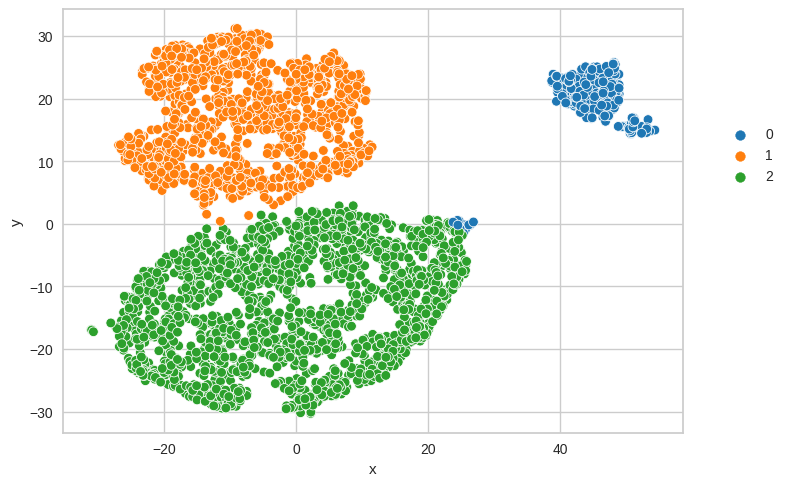

In [25]:
sns.scatterplot(data=X_embedded, x='x', y='y', hue='labels_tSNE_3g',
                palette=sns.color_palette("tab10", 3))
plt.legend(bbox_to_anchor=(1.05,0.75))
plt.show()

In [26]:
multiple_time_buyers = raw_X.merge(X_embedded, on='customer_unique_id')

fts = ['monetary_value_sum',
       'total_number_of_purchases',
       'elapsed_days_since_last_purchase']

multiple_time_buyers.head()

monetary_value_sum  \
customer_unique_id                                     
00172711b30d52eea8b313a7f2cced02              122.07   
004288347e5e88a27ded2bb23747066c              354.37   
004b45ec5c64187465168251cd1c9c2f              147.72   
0058f300f57d7b93c477a131a59b36c3              175.58   
00a39521eb40f7012db50455bf083460              123.25   

                                  monetary_value_mean_per_order  \
customer_unique_id                                                
00172711b30d52eea8b313a7f2cced02                         61.035   
004288347e5e88a27ded2bb23747066c                        177.185   
004b45ec5c64187465168251cd1c9c2f                         73.860   
0058f300f57d7b93c477a131a59b36c3                         87.790   
00a39521eb40f7012db50455bf083460                         61.625   

                                  total_number_of_purchases  \
customer_unique_id                                            
00172711b30d52eea8b313a7f2cced02                          2   
004288347e5e88a27ded2bb23747066c                          2   
004b45ec5c64187465168251cd1c9c2f                          2   
0058f300f57d7b93c477a131a59b36c3                          2   
00a39521eb40f7012db50455bf083460                          2   

                                  number_of_purchases_last_365_days  \
customer_unique_id                                                    
00172711b30d52eea8b313a7f2cced02                                  2   
004288347e5e88a27ded2bb23747066c                                  1   
004b45ec5c64187465168251cd1c9c2f                                  1   
0058f300f57d7b93c477a131a59b36c3                                  2   
00a39521eb40f7012db50455bf083460                                  2   

                                  number_of_purchases_last_90_days  \
customer_unique_id                                                   
00172711b30d52eea8b313a7f2cced02                                 2   
004288347e5e88a27ded2bb23747066c                                 0   
004b45ec5c64187465168251cd1c9c2f                                 0   
0058f300f57d7b93c477a131a59b36c3                                 0   
00a39521eb40f7012db50455bf083460                                 0   

                                  number_of_purchases_last_30_days  \
customer_unique_id                                                   
00172711b30d52eea8b313a7f2cced02                                 0   
004288347e5e88a27ded2bb23747066c                                 0   
004b45ec5c64187465168251cd1c9c2f                                 0   
0058f300f57d7b93c477a131a59b36c3                                 0   
00a39521eb40f7012db50455bf083460                                 0   

                                  elapsed_days_since_last_purchase  \
customer_unique_id                                                   
00172711b30d52eea8b313a7f2cced02                                65   
004288347e5e88a27ded2bb23747066c                               276   
004b45ec5c64187465168251cd1c9c2f                               143   
0058f300f57d7b93c477a131a59b36c3                               208   
00a39521eb40f7012db50455bf083460                               136   

                                  number_of_items_ordered_max  \
customer_unique_id                                              
00172711b30d52eea8b313a7f2cced02                          1.0   
004288347e5e88a27ded2bb23747066c                          1.0   
004b45ec5c64187465168251cd1c9c2f                          1.0   
0058f300f57d7b93c477a131a59b36c3                          1.0   
00a39521eb40f7012db50455bf083460                          1.0   

                                  number_of_items_ordered_min  \
customer_unique_id                                              
00172711b30d52eea8b313a7f2cced02                          1.0   
004288347e5e88a27ded2bb23747066c                          1.0   
004b45ec5c64187465168251cd1c9c2f          

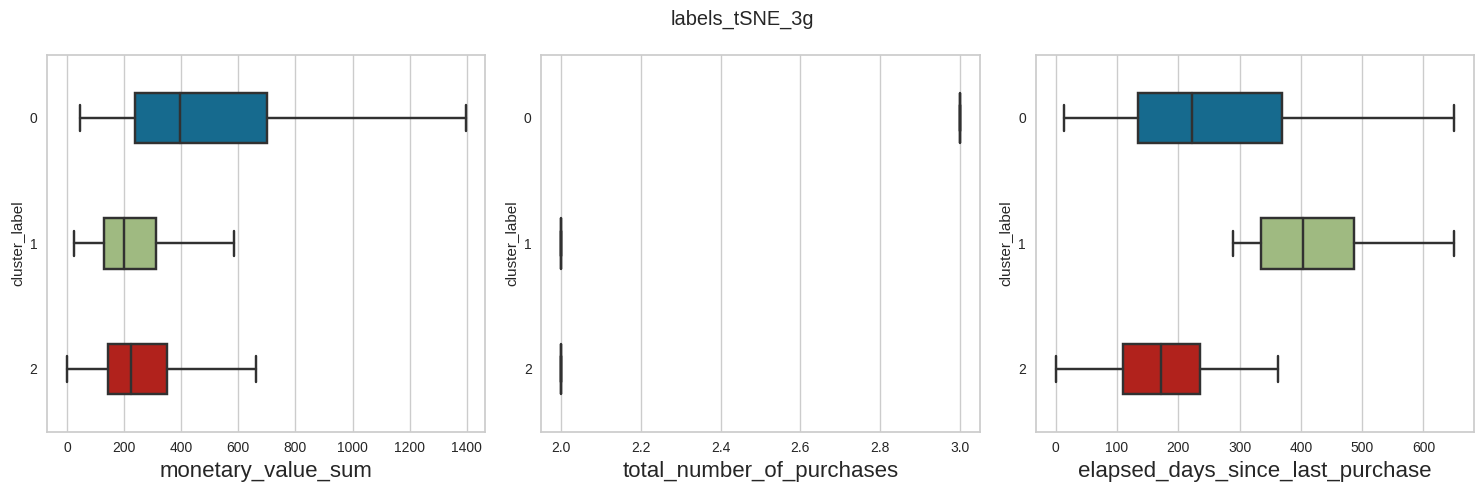

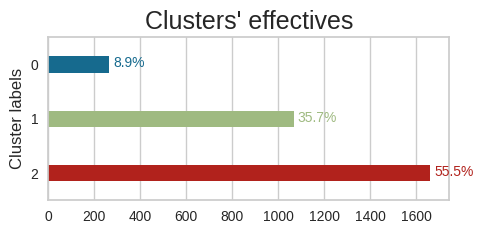

In [28]:
ds.display_clusters_comparison(multiple_time_buyers[fts].copy(),
                               multiple_time_buyers.labels_tSNE_3g,)

The smallest cluster is about customers who bought more than 3 times and for an important amount of money. 

The 2 remaining clusters have a tendency to split customers according their recency (only bought twice).

## 1.3.  [&#9650;](#toc0_) <a id='toc1_3_'></a>Kmeans

In this section, Kmeans clustering are performed both on Xpp and Xppr (robust pre-processing) in order to evaluate what works best.

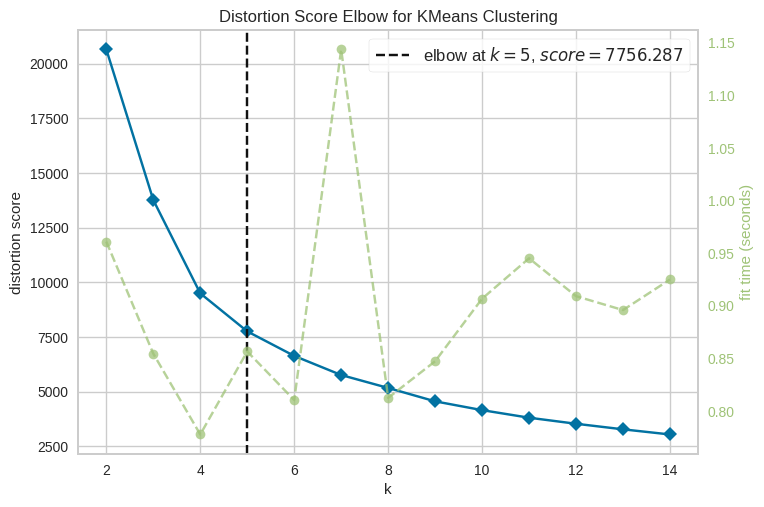

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
elbow = KElbowVisualizer(KMeans(n_init=10), k=(2,15))
elbow.fit(Xspp)
elbow.show()

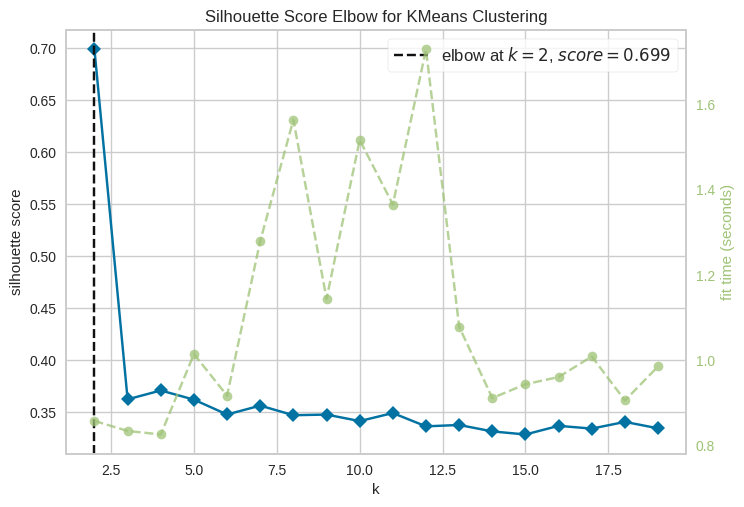

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [11]:
elbow = KElbowVisualizer(KMeans(n_init=10), k=(2, 20), metric='silhouette')
elbow.fit(Xspp)
elbow.show()

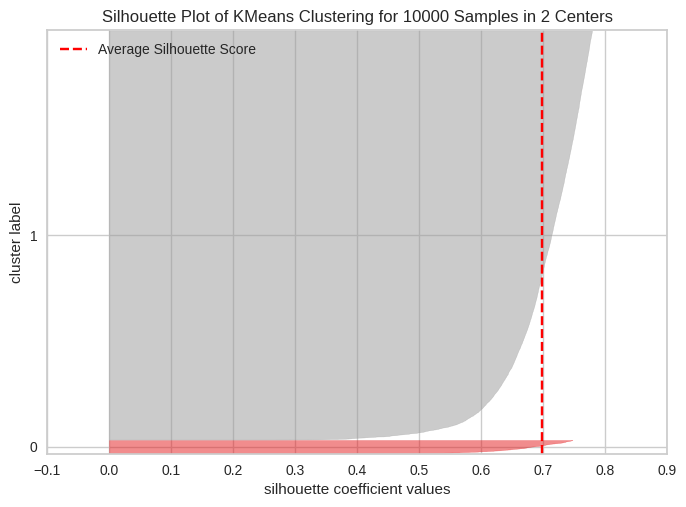

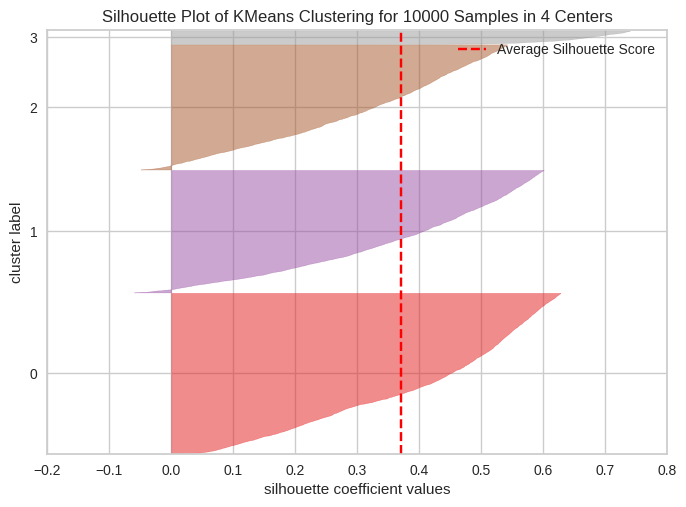

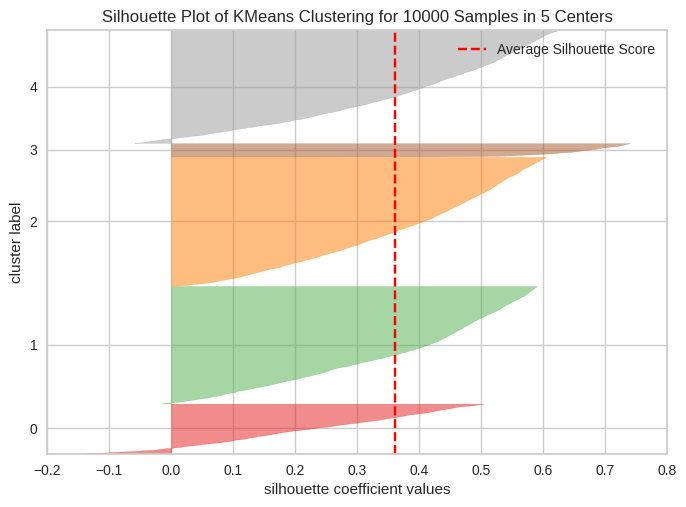

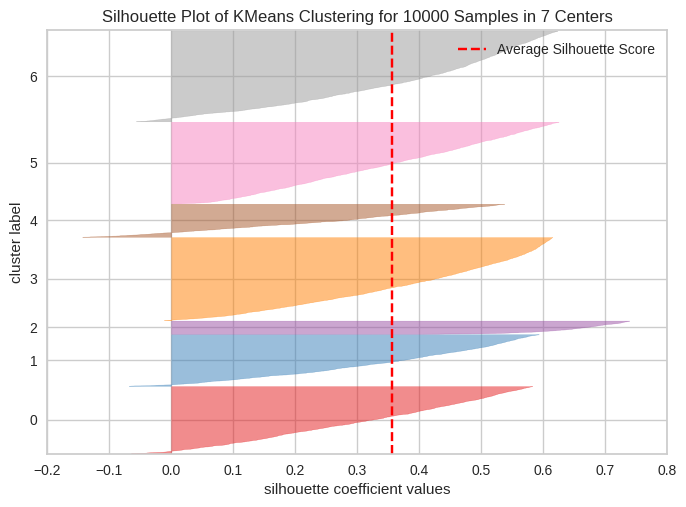

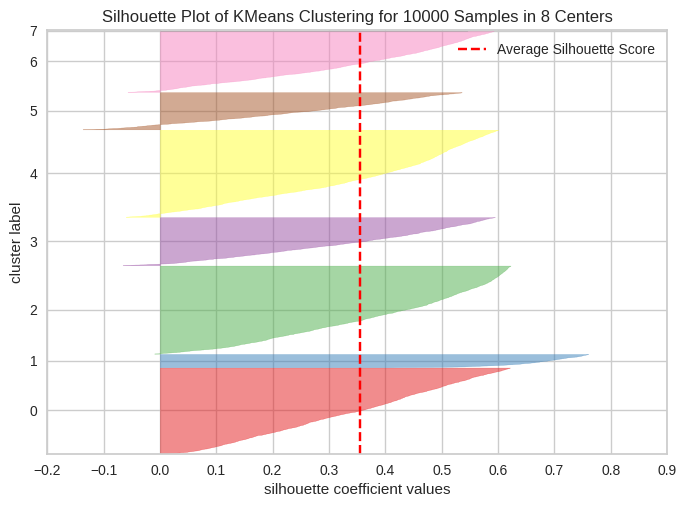

In [10]:
# Display silhouettes values per clusters
# for the best candidates for k.
for n_clusters in [2, 4, 5, 7, 8]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    vis = SilhouetteVisualizer(kmeans)
    vis.fit(Xspp)
    vis.show()

The best clustering option is obviously to split the data in two groups. This was clearly seen on the pca projections during the EDA (visualizing the RFM segmentation).
It will possibly correspond to one time buyer, and multiple time buyers.

Nevertheless, it is not very informative and will not provide nice groups to help the marketing team.

We can note that a 4-group-division or a 7-group-division also seems interesting.
Let's compute those 3 on the full dataset.

In [12]:
# Set the Kmeans clusterers
kmeans_2g = KMeans(n_clusters=2, n_init=10)
kmeans_4g = KMeans(n_clusters=4, n_init=10)
kmeans_7g = KMeans(n_clusters=7, n_init=10)
kmeans_8g = KMeans(n_clusters=8, n_init=10)

# Compute results and add in the df.
X.loc[:, 'xpp_label_2g'] = kmeans_2g.fit_predict(Xpp)
X.loc[:, 'xpp_label_4g'] = kmeans_4g.fit_predict(Xpp)
X.loc[:, 'xpp_label_7g'] = kmeans_7g.fit_predict(Xpp)

# Save centroids
centroids_pp_space = {'Kmeans_2g': kmeans_2g.cluster_centers_,
                      'Kmeans_4g': kmeans_4g.cluster_centers_,
                      'Kmeans_7g': kmeans_7g.cluster_centers_,}

# Compute results and add in the df.
X.loc[:, 'xppr_label_2g'] = kmeans_2g.fit_predict(Xppr)
X.loc[:, 'xppr_label_4g'] = kmeans_4g.fit_predict(Xppr)
X.loc[:, 'xppr_label_7g'] = kmeans_7g.fit_predict(Xppr)

# Insert results in the Xs df
Xs = X.loc[Xs.index, :]

# Save centroids
centroids_ppr_space = {'Kmeans_2g': kmeans_2g.cluster_centers_,
                       'Kmeans_4g': kmeans_4g.cluster_centers_,
                       'Kmeans_7g': kmeans_7g.cluster_centers_,}


In [13]:
# On the sampled dataset for tSNE.
tsne = TSNE(n_components=2, perplexity=85)
X_tsne_pp = tsne.fit_transform(Xspp)
X_tsne_ppr = tsne.fit_transform(Xsppr)  

In [14]:
X_tsne_pp = pd.DataFrame(X_tsne_pp, index=Xs.index, columns=['x','y'])
X_tsne_ppr = pd.DataFrame(X_tsne_ppr, index=Xs.index, columns=['x','y'])

In [15]:
kmeans_label_names = ['xpp_label_2g', 'xpp_label_4g', 'xpp_label_7g',
                      'xppr_label_2g', 'xppr_label_4g', 'xppr_label_7g',]

tsne_labels_df = X.loc[X_tsne_pp.index, kmeans_label_names]

X_tsne_pp = X_tsne_pp.merge(tsne_labels_df, on='customer_unique_id')
X_tsne_ppr = X_tsne_ppr.merge(tsne_labels_df, on='customer_unique_id')

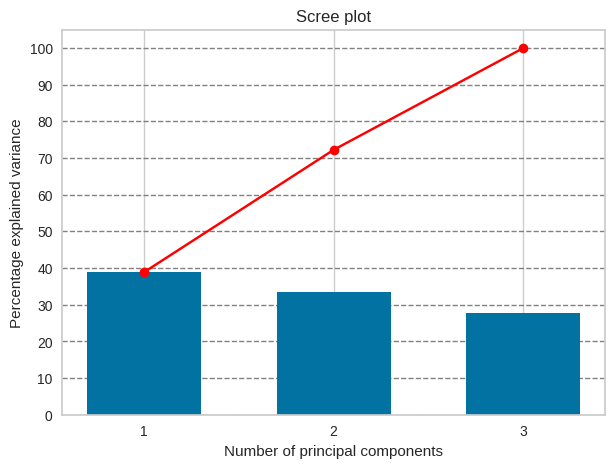

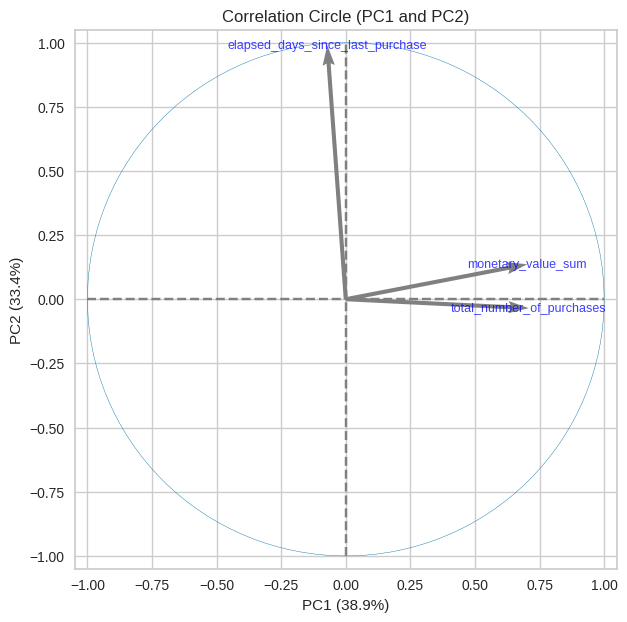

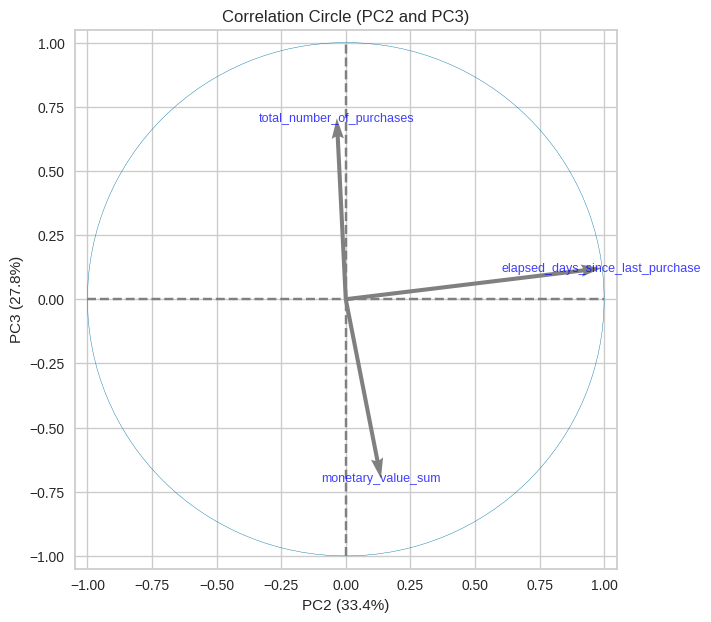

************
xpp_label_2g


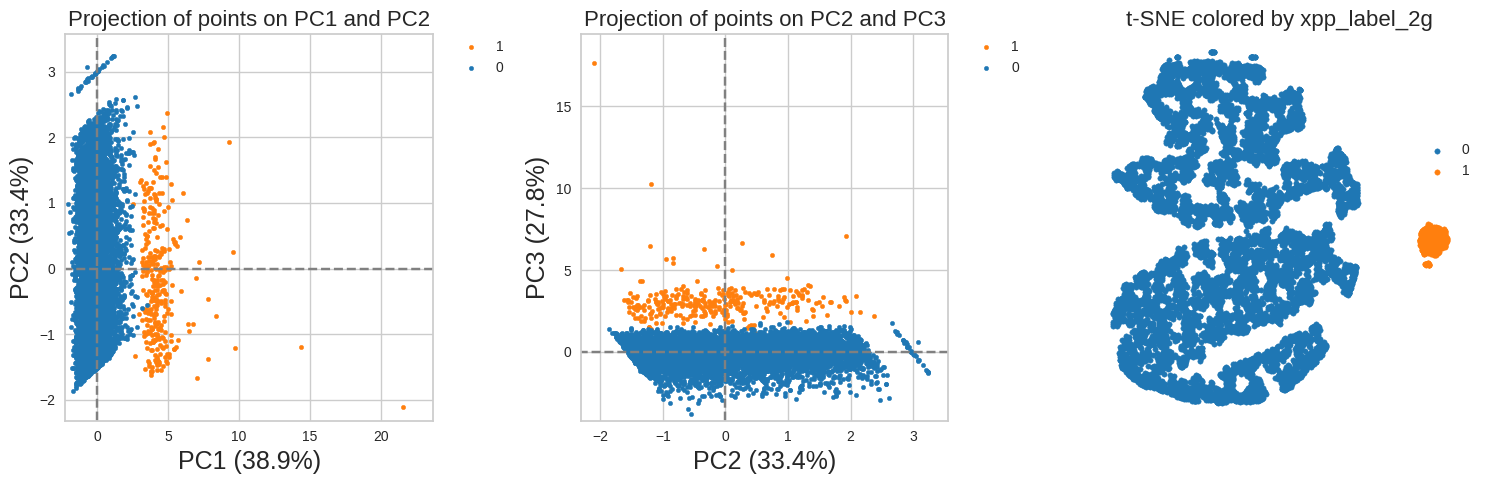

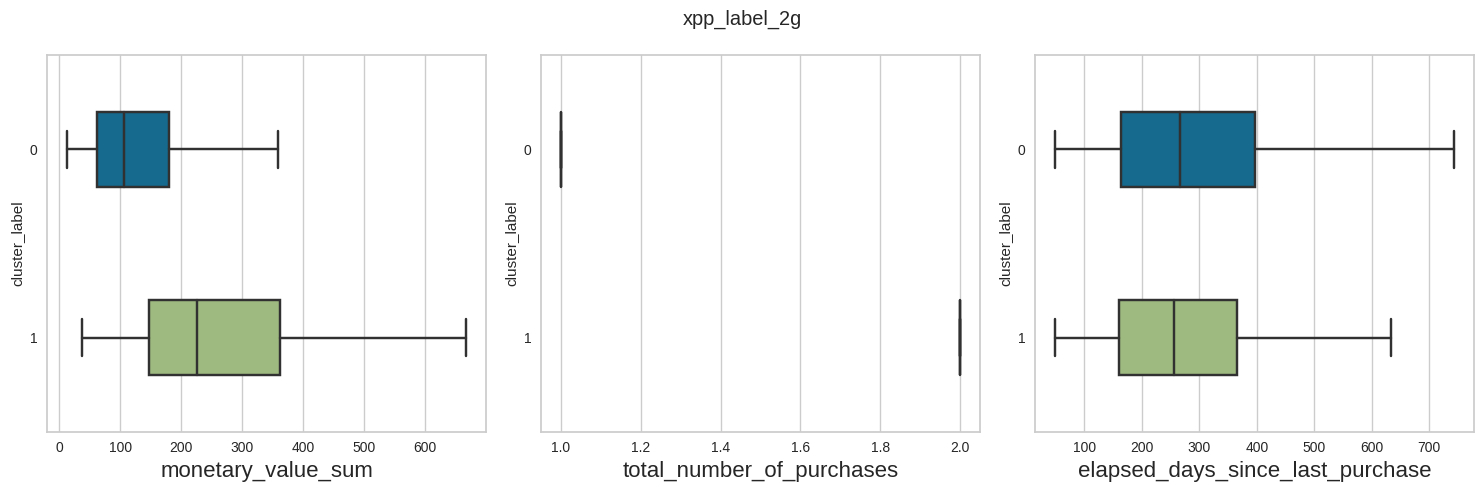

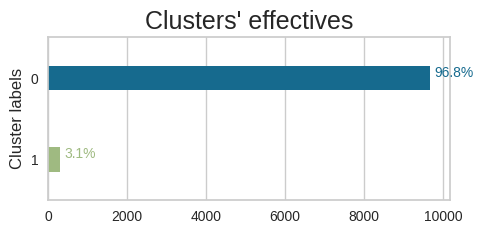

************
xpp_label_4g


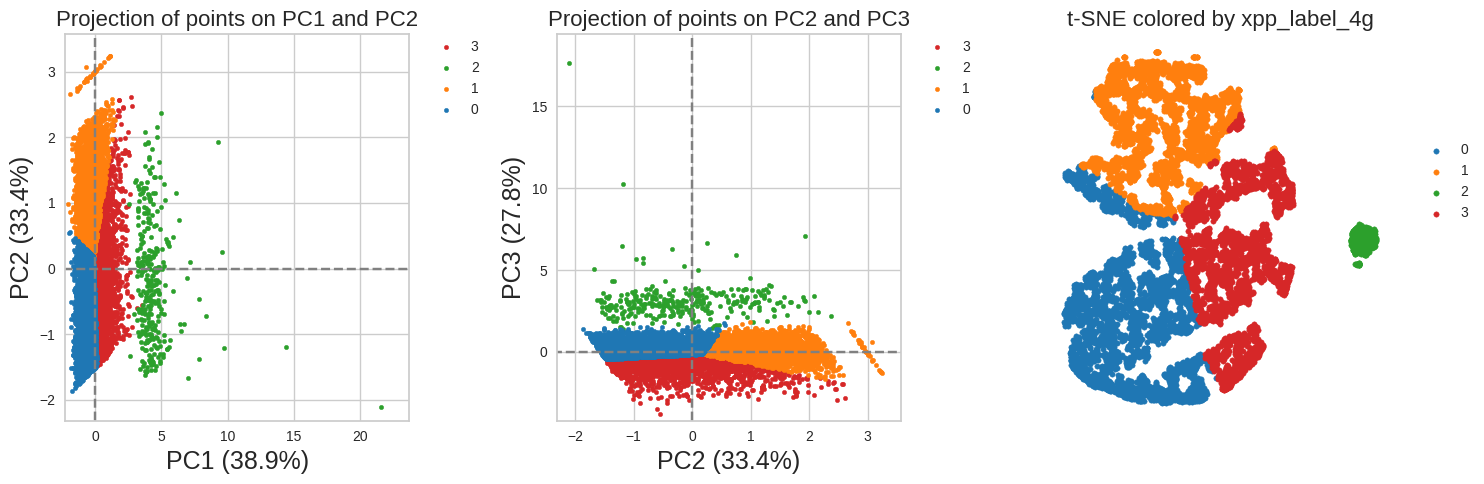

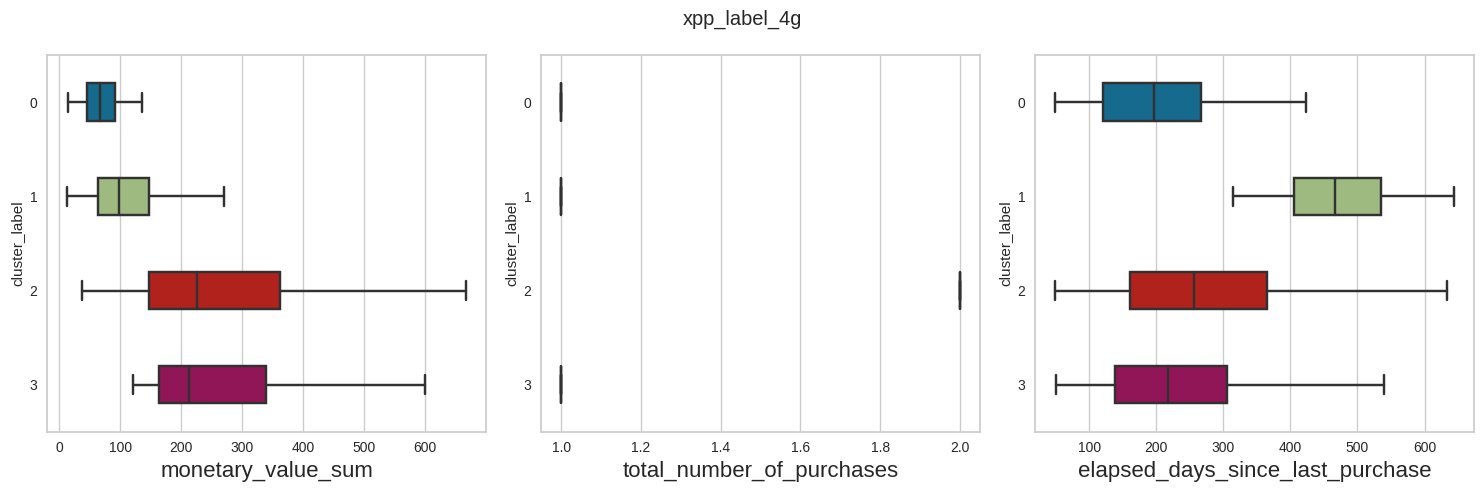

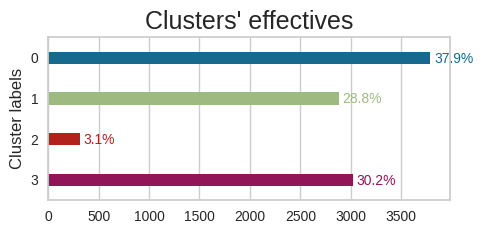

************
xpp_label_7g


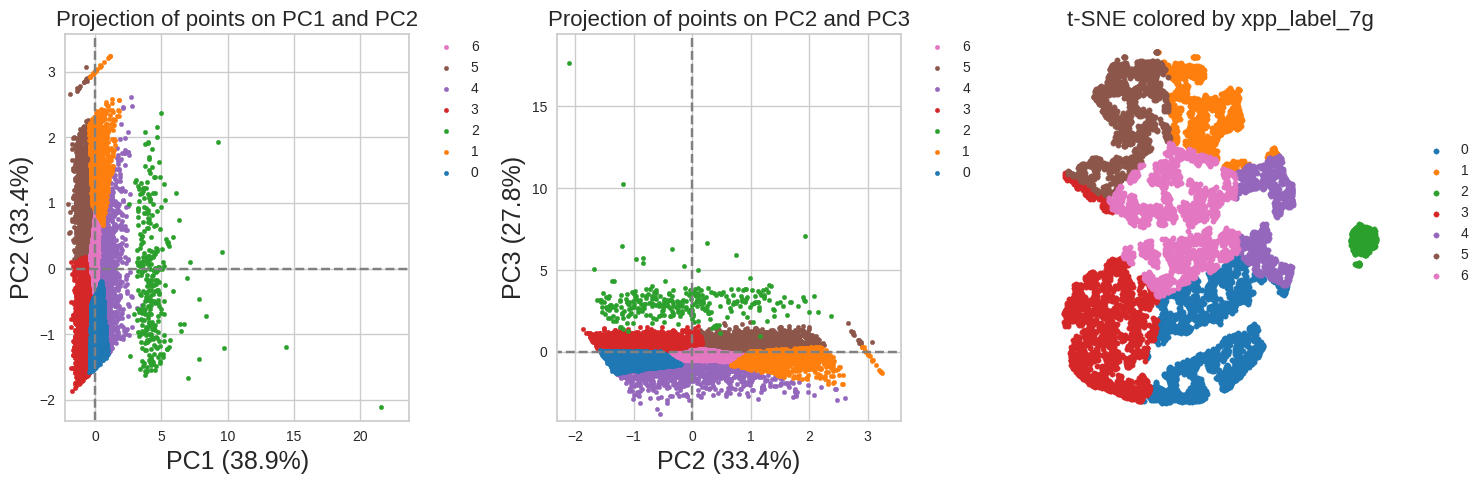

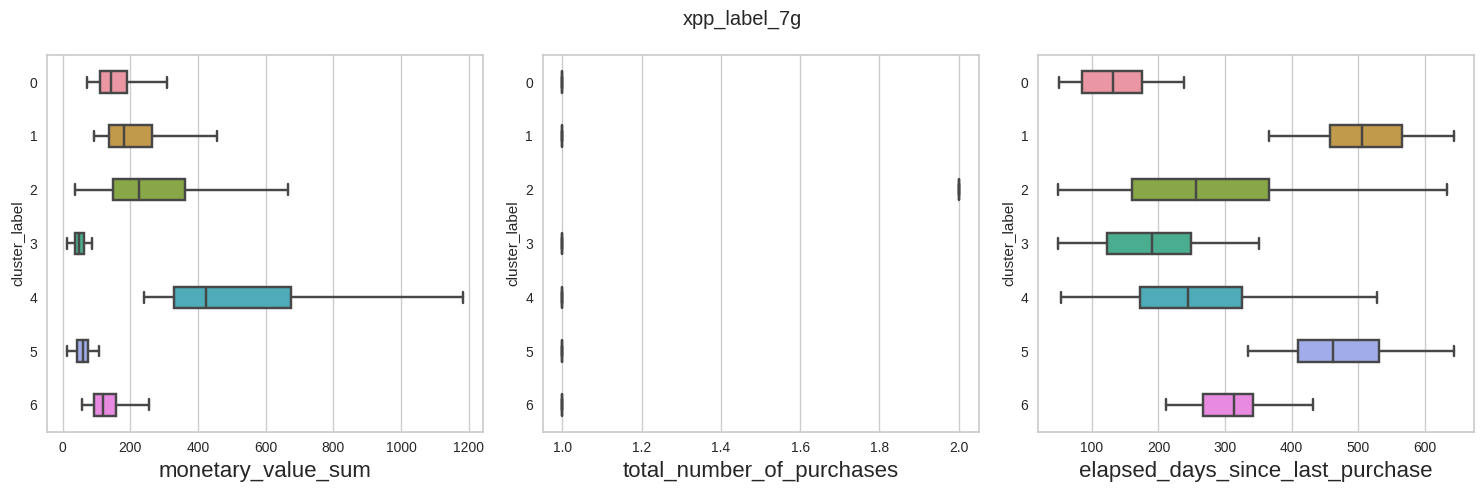

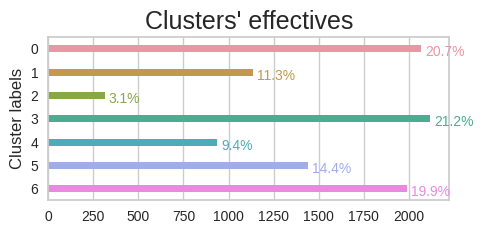

************
xppr_label_2g


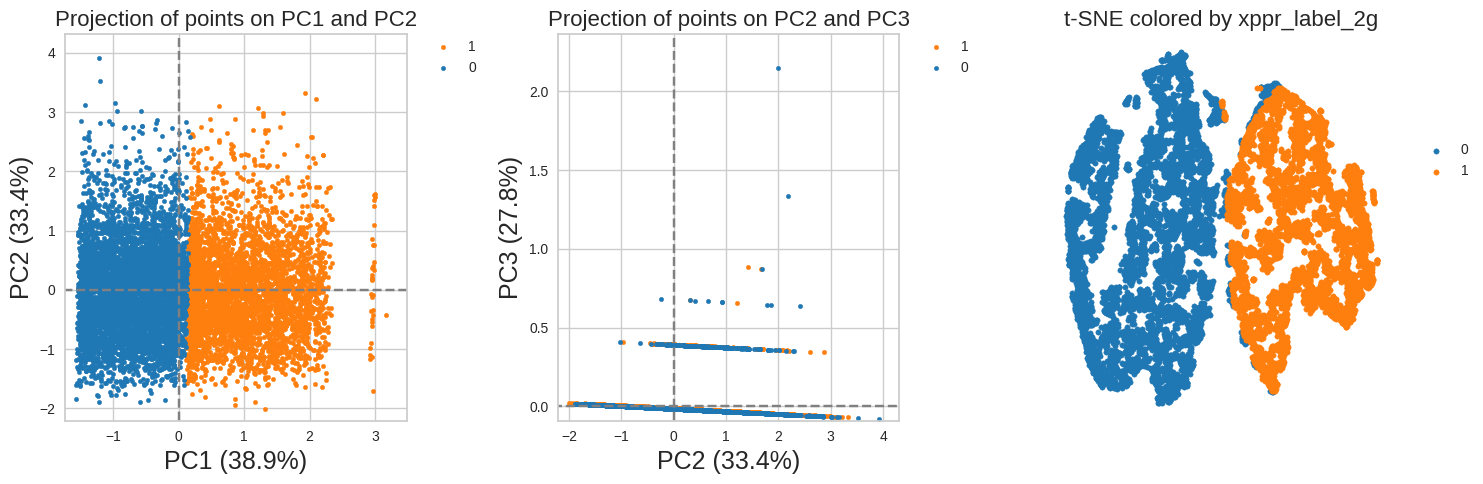

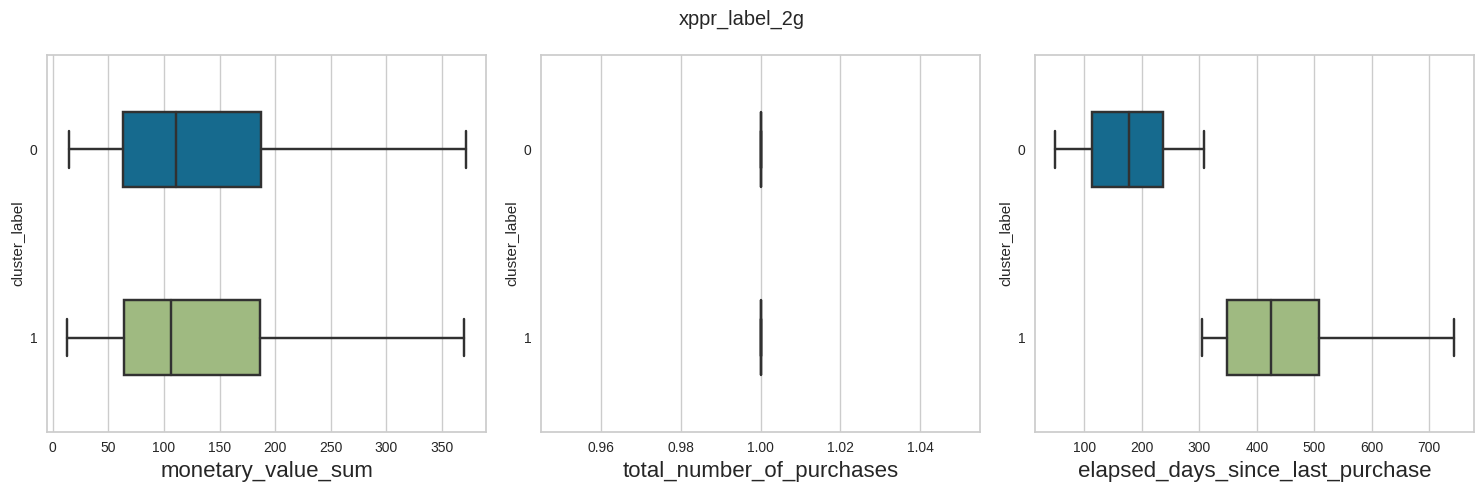

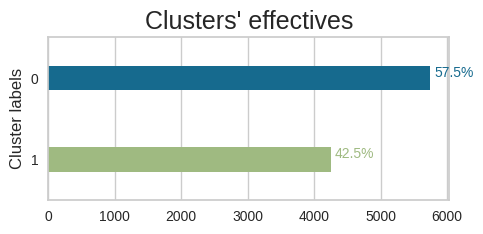

************
xppr_label_4g


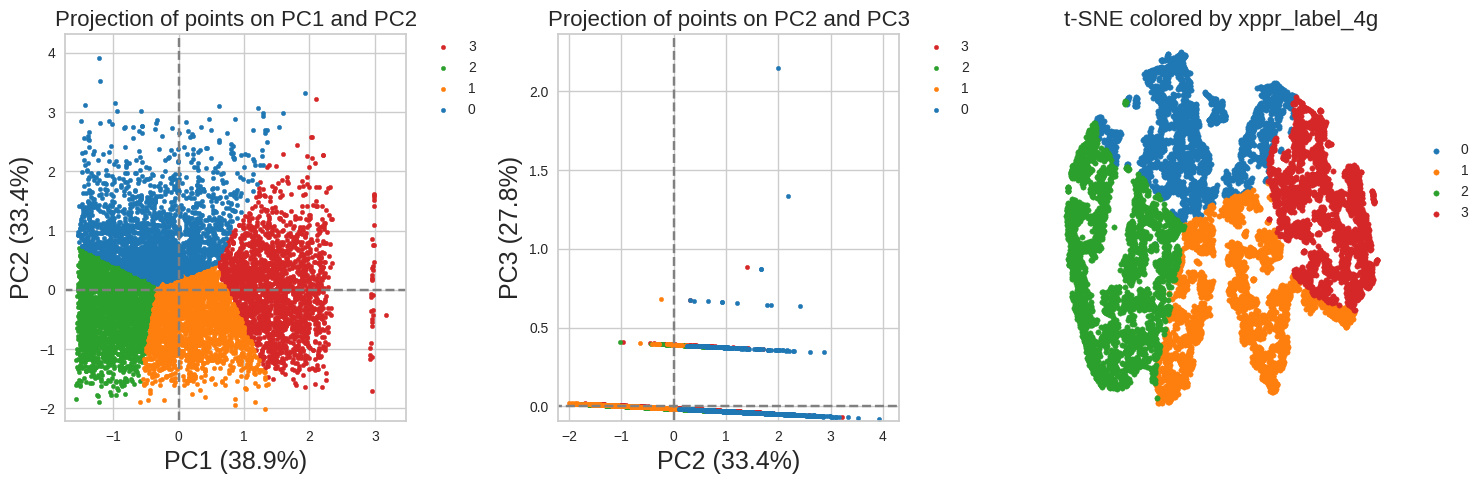

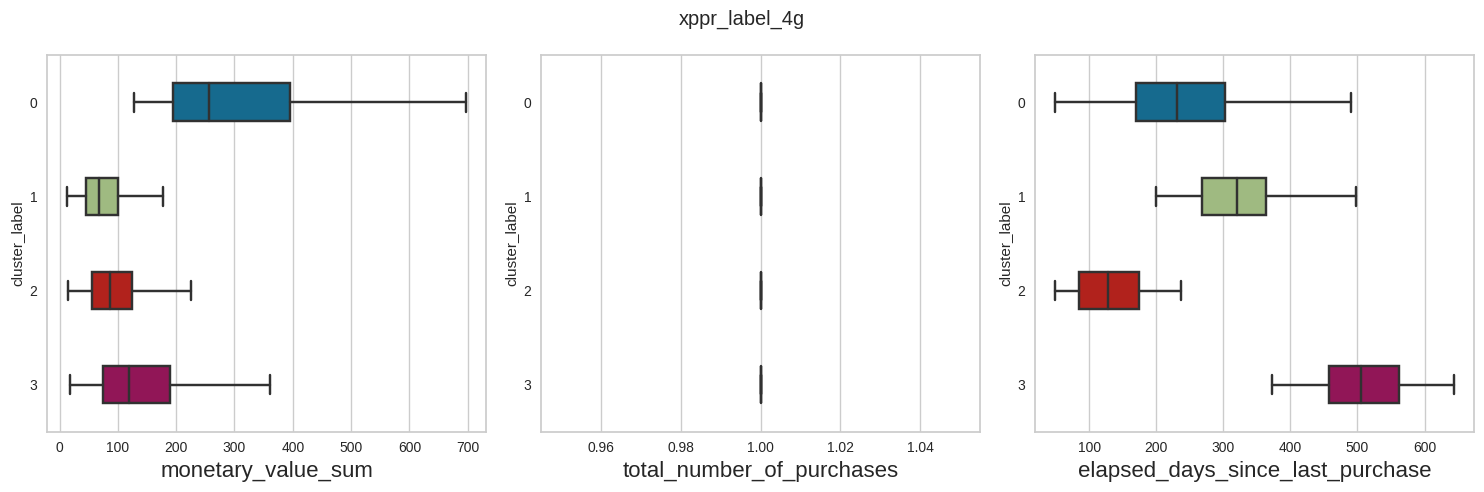

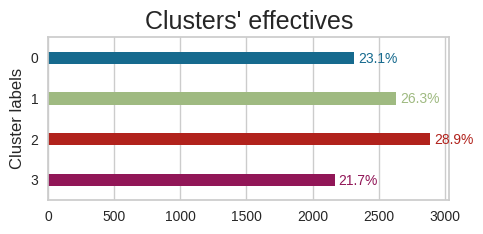

************
xppr_label_7g


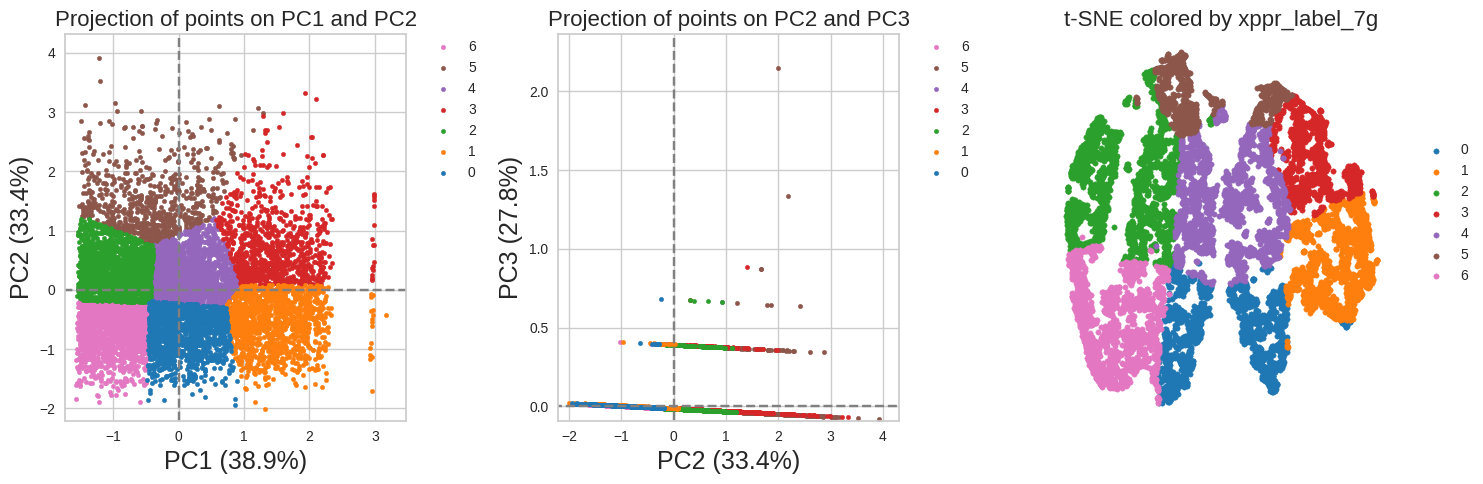

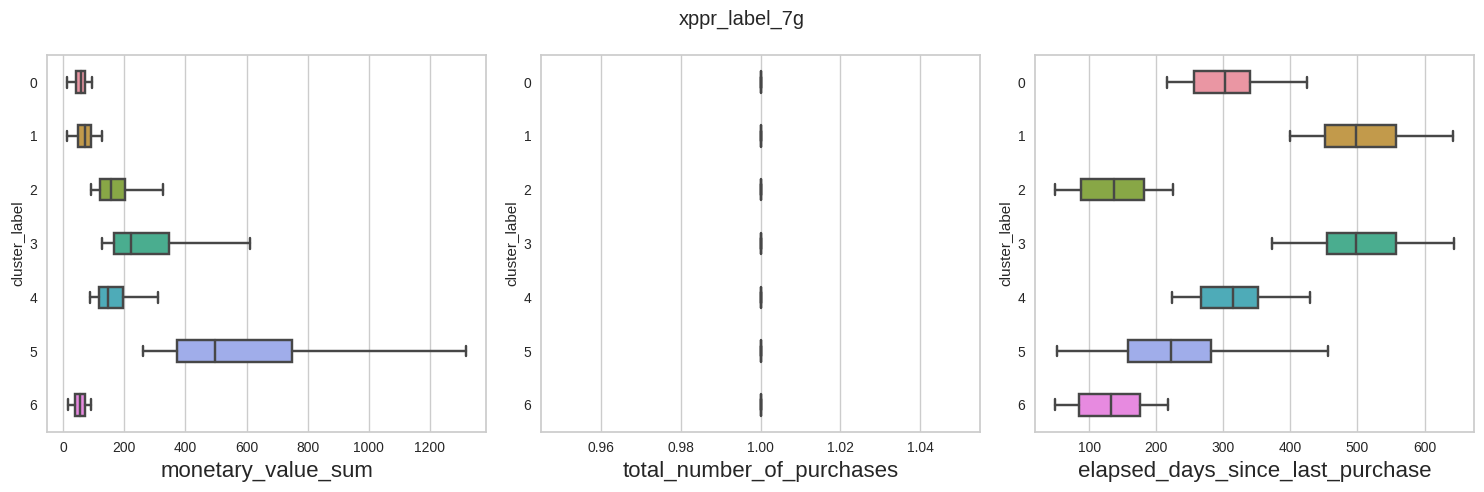

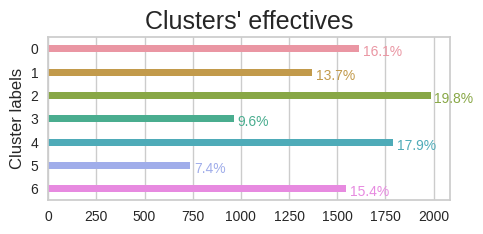

In [19]:
%matplotlib inline

pca = PCA()
X_proj_ppr = pca.fit_transform(Xsppr)
pca = PCA()
X_proj_pp = pca.fit_transform(Xspp)

ds.display_scree_plot(pca)
ds.display_correlation_circle(pca, (0, 1), all_fts)
ds.display_correlation_circle(pca, (1, 2), all_fts)
palette = sns.color_palette("tab10")

for label_name in kmeans_label_names:
        label_vec = Xs[label_name]
        print('************')
        print(f'{label_name}')
        if 'xppr' in label_name:
                X_tsne = X_tsne_ppr.values
                X_proj = X_proj_ppr
        else: 
                X_tsne = X_tsne_pp.values
                X_proj = X_proj_pp
                
        ds.display_clusters_in_pca_space_and_tsne_embedding(
            X_proj, pca, X_tsne, label_vec, label_name
        )
        ds.display_clusters_comparison(Xs[fts].copy(), Xs[label_name])

We clearly see that the pre-processing with standard scaler is better than the one with the robust scaler because it separates the clients meaningfully making groups of multiple-ime buyers and one-time buyers. That is a very important feature I want the clustering to reveal. 

## 1.4.  [&#9650;](#toc0_) <a id='toc1_4_'></a>Hierarchical clustering

ward


/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


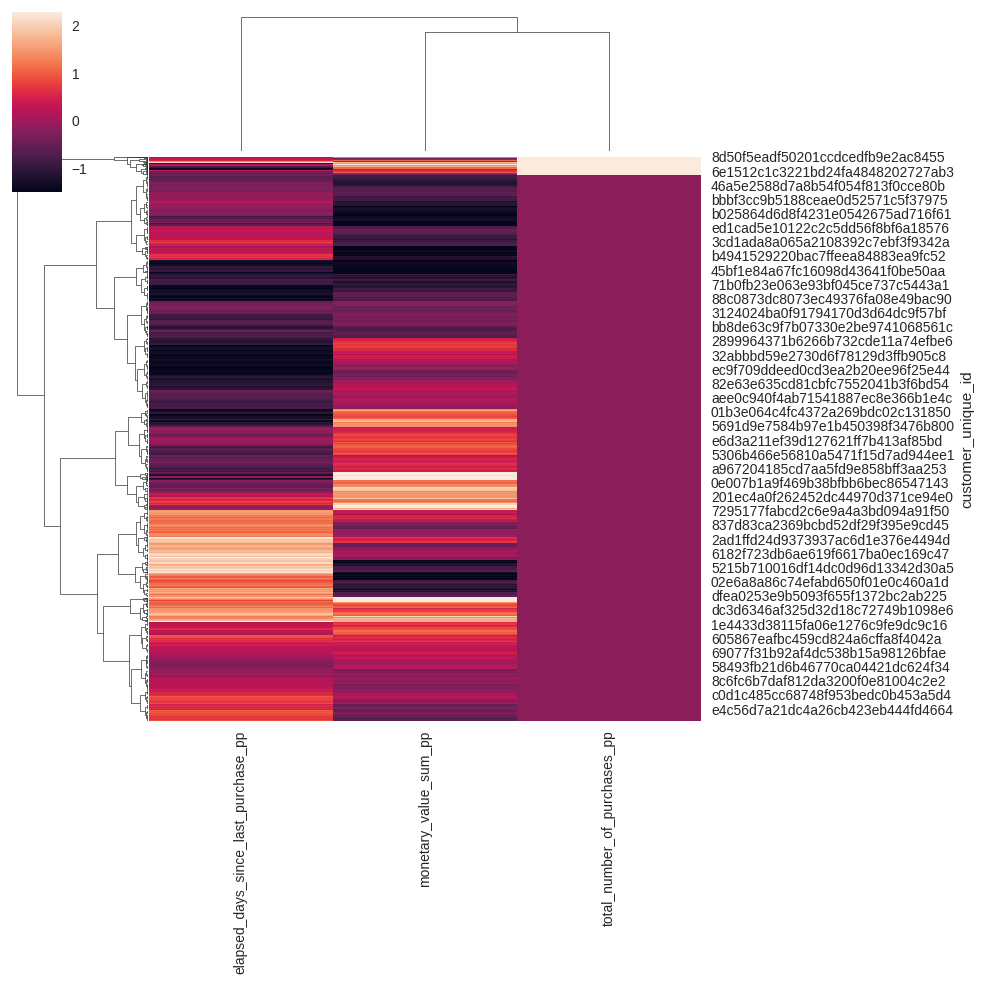

average


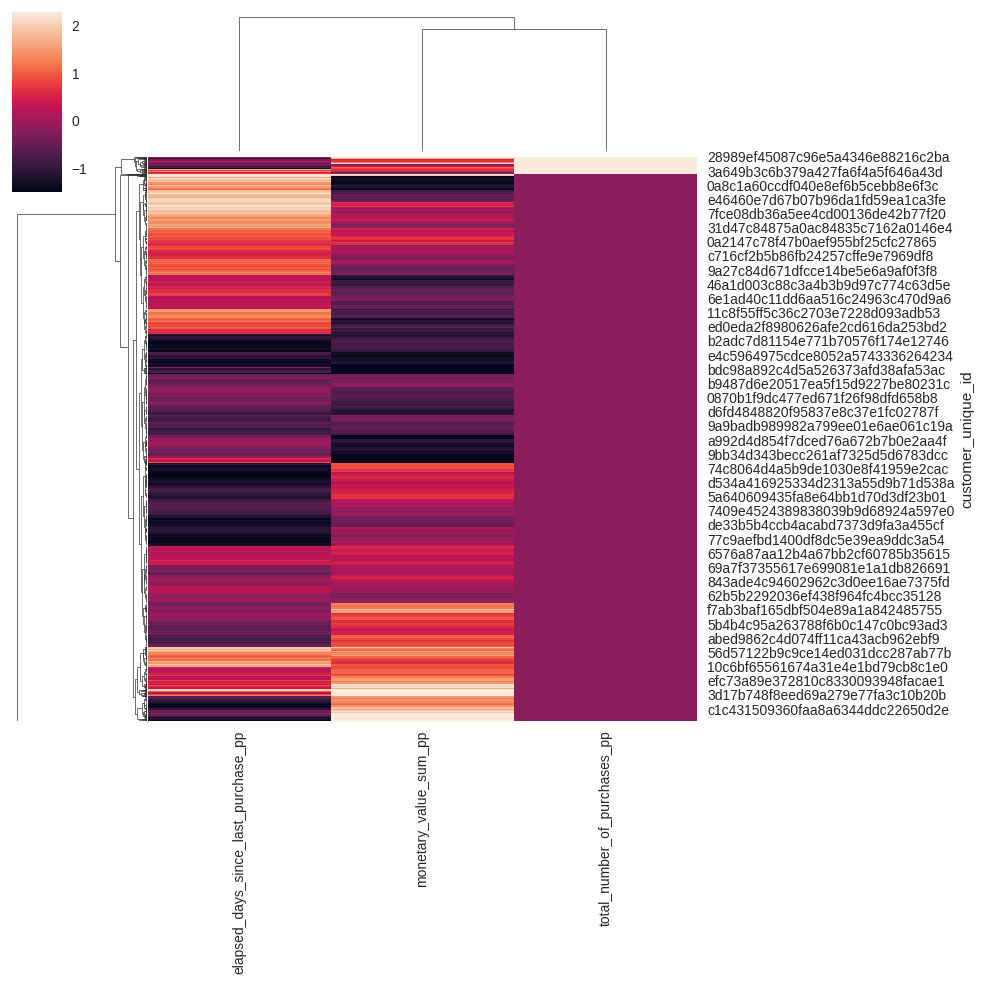

complete


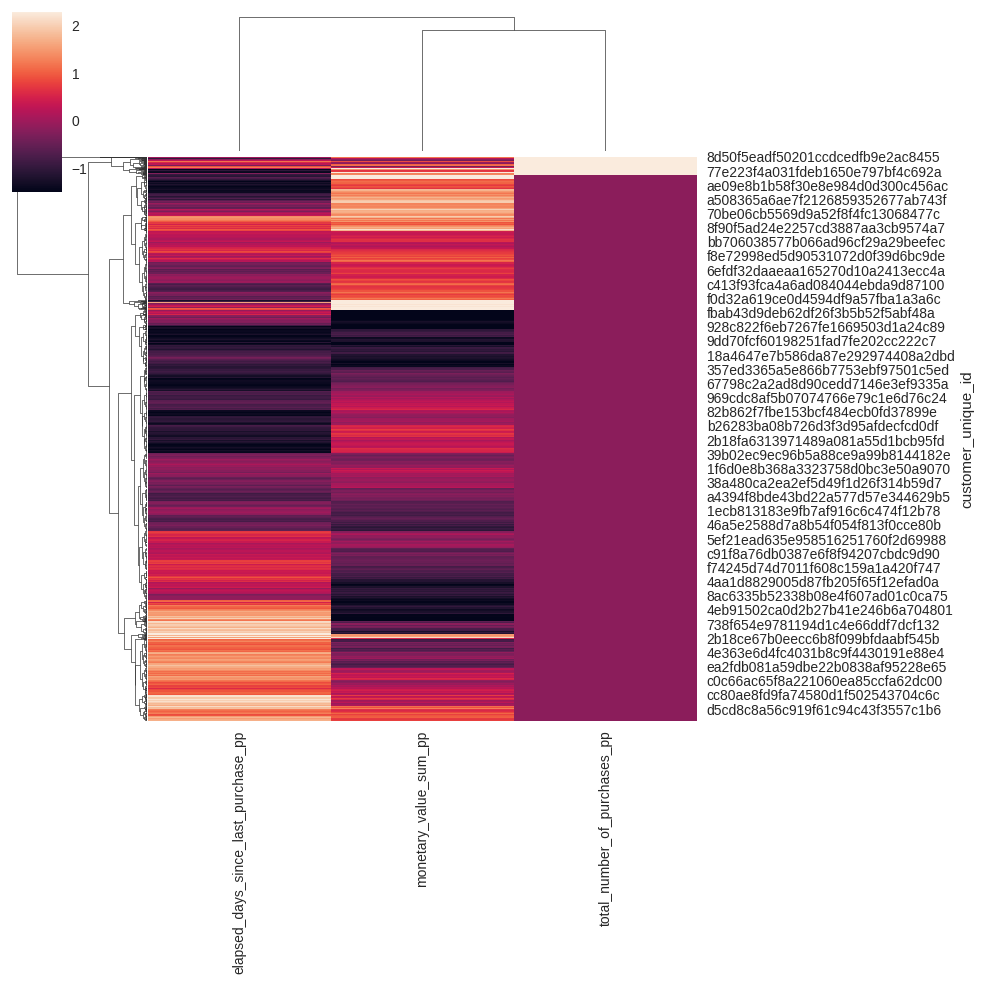

single


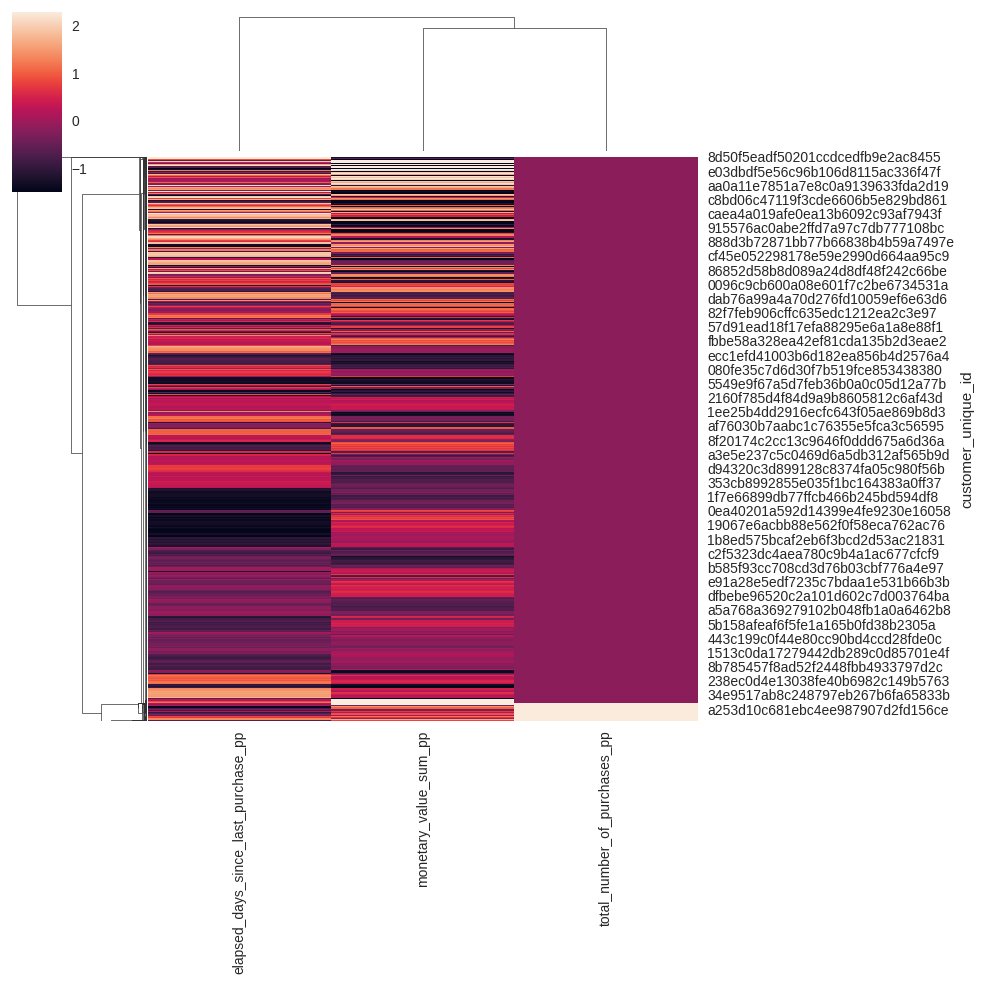

In [4]:
for linkage in ("ward", "average", "complete", "single"):
    print(linkage)
    sns.clustermap(Xspp, method=linkage, robust=True)
    plt.show()

ward
ward :	4.56s


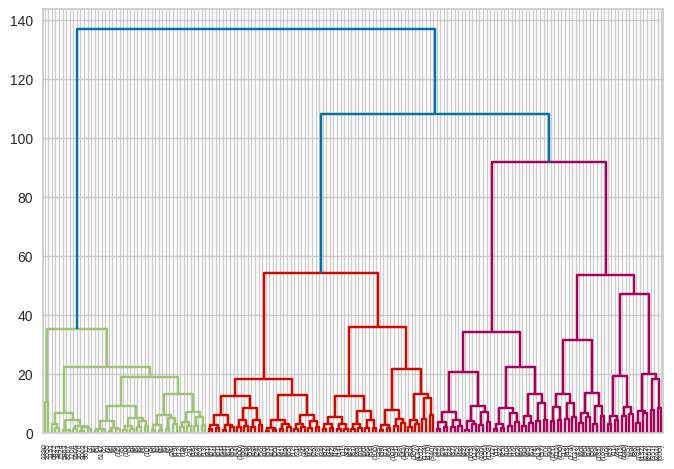

average
average :	4.45s


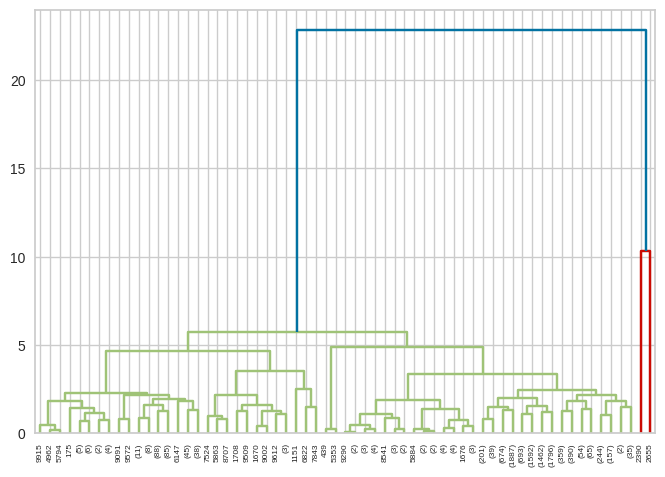

complete
complete :	4.39s


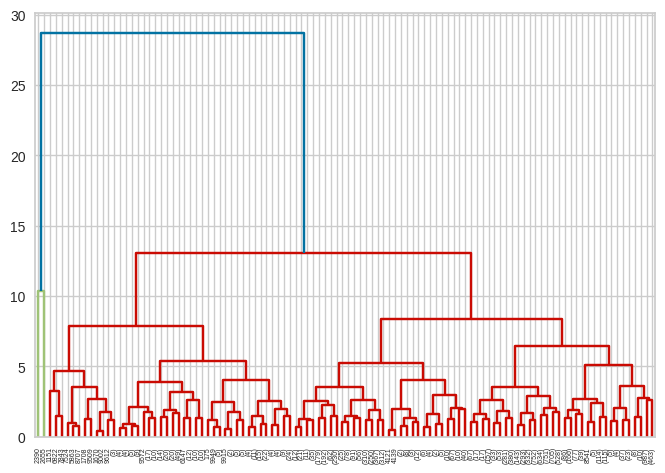

single
single :	1.21s


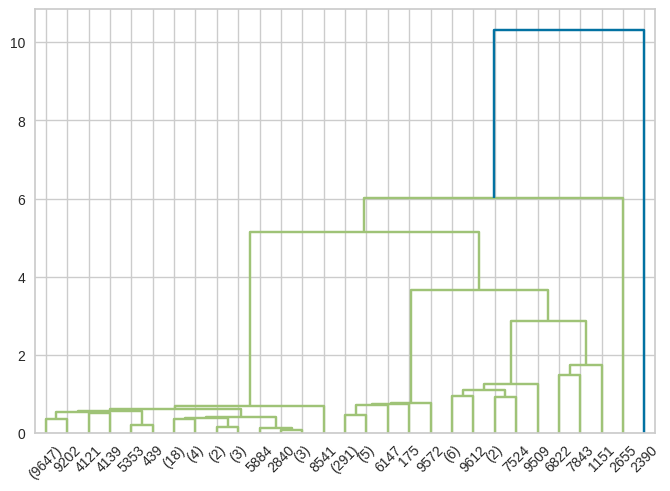

In [6]:
from time import time
for linkage in ("ward", "average", "complete", "single"):
    print(linkage)
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        distance_threshold=0,
                                        n_clusters=None)
    t0 = time()
    clusterer.fit(Xspp)
    print("%s :\t%.2fs" % (linkage, time() - t0))
    ds.plot_dendrogram(clusterer, truncate_mode="level", p=7)
    plt.show()


Let's explore some distinct clustering decided from the above dendograms and clustermaps (on the sampled version for time purpose).

In [4]:
# Compute labels with different parameters.
clusterer = AgglomerativeClustering(linkage='single',
                                    n_clusters=6)
clusterer.fit(Xspp)
Xs['label_hierarchical_single_6g'] = clusterer.labels_

clusterer = AgglomerativeClustering(linkage='complete',
                                    n_clusters=10)
clusterer.fit(Xspp)
Xs['label_hierarchical_complete_10g'] = clusterer.labels_

clusterer = AgglomerativeClustering(linkage='ward',
                                    n_clusters=6)
clusterer.fit(Xspp)
Xs['label_hierarchical_ward_6g'] = clusterer.labels_

clusterer = AgglomerativeClustering(linkage='ward',
                                    n_clusters=11)
clusterer.fit(Xspp)
Xs['label_hierarchical_ward_11g'] = clusterer.labels_

clusterer = AgglomerativeClustering(linkage='average',
                                    n_clusters=8)
clusterer.fit(Xspp)
Xs['label_hierarchical_average_8g'] = clusterer.labels_

clusterer = AgglomerativeClustering(linkage='average',
                                    n_clusters=11)
clusterer.fit(Xspp)
Xs['label_hierarchical_average_11g'] = clusterer.labels_


In [5]:
X_tsne = TSNE(n_components=2, perplexity=85, n_jobs=-1).fit_transform(Xspp)
pca = PCA()
pca.fit(Xpp)
X_proj = pca.transform(Xspp)

**** label_hierarchical_single_6g ****


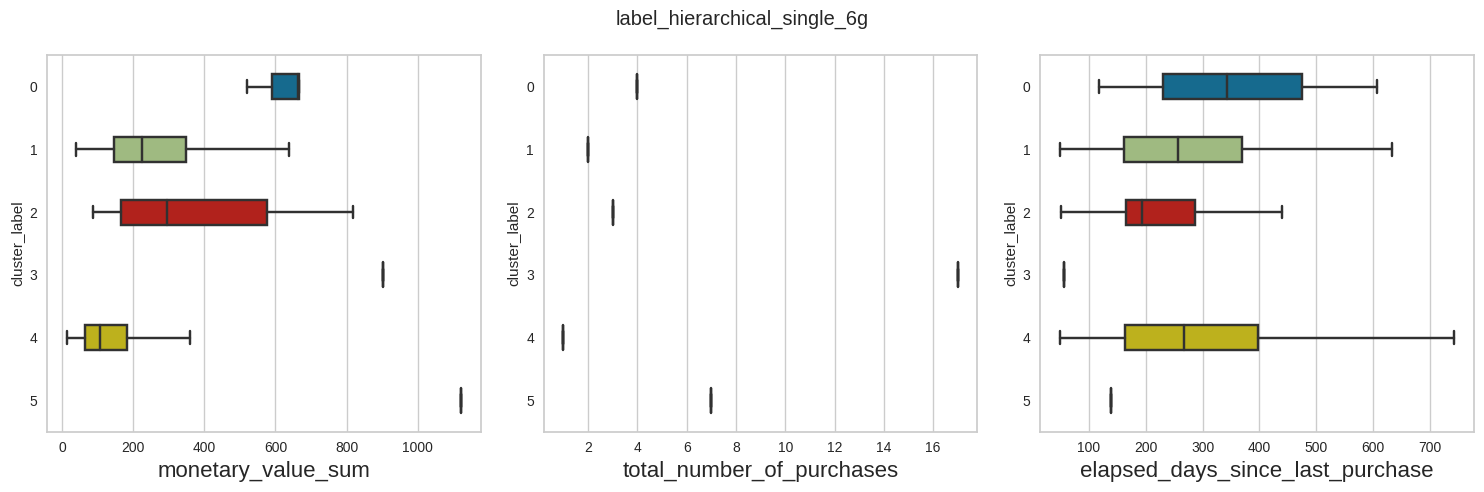

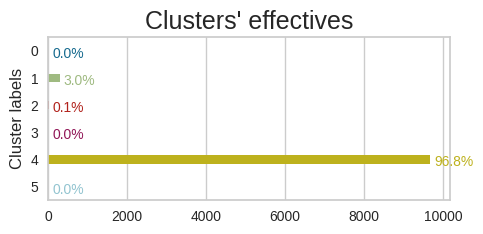

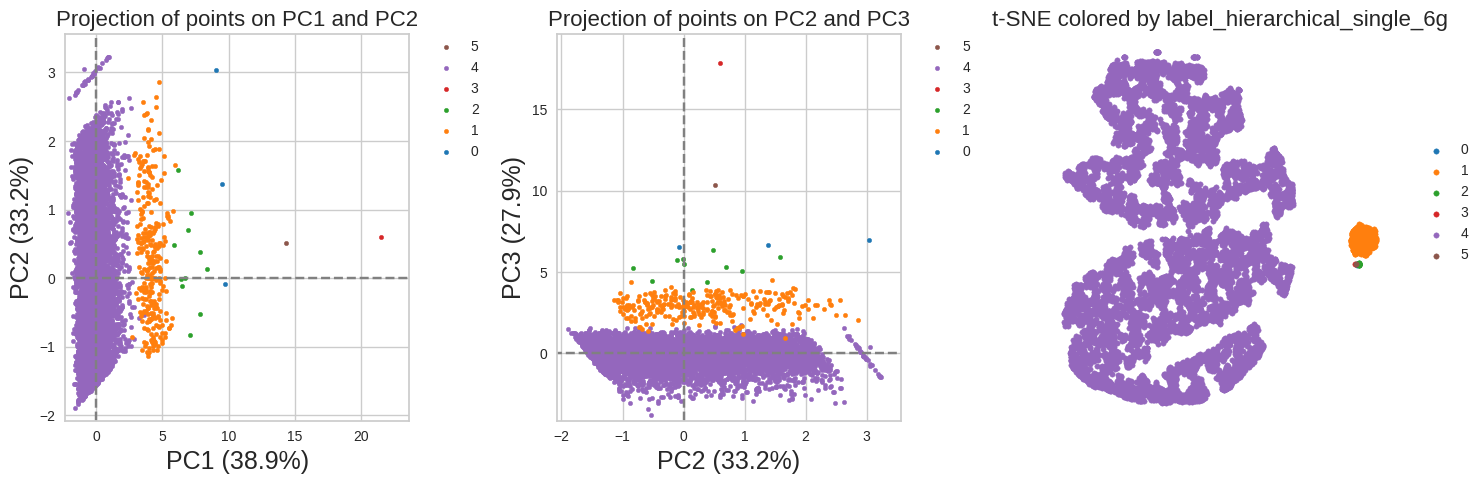

**** label_hierarchical_complete_10g ****


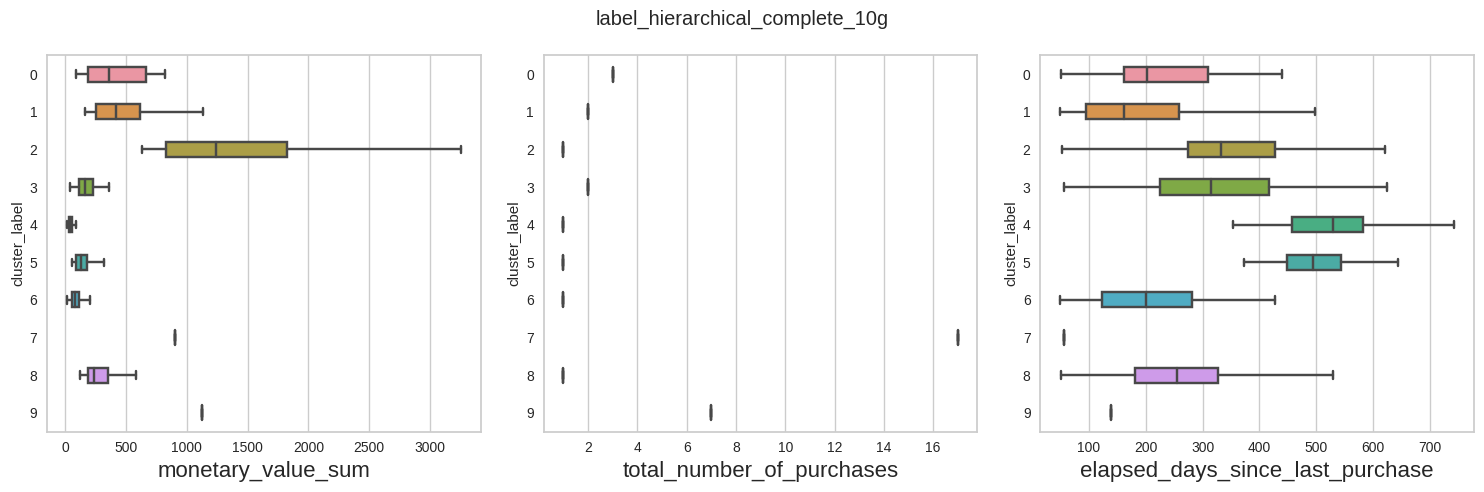

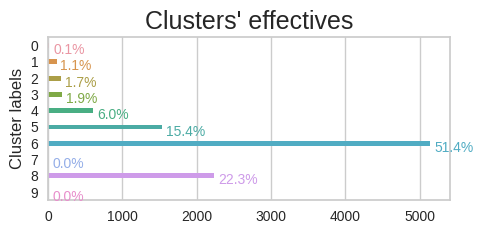

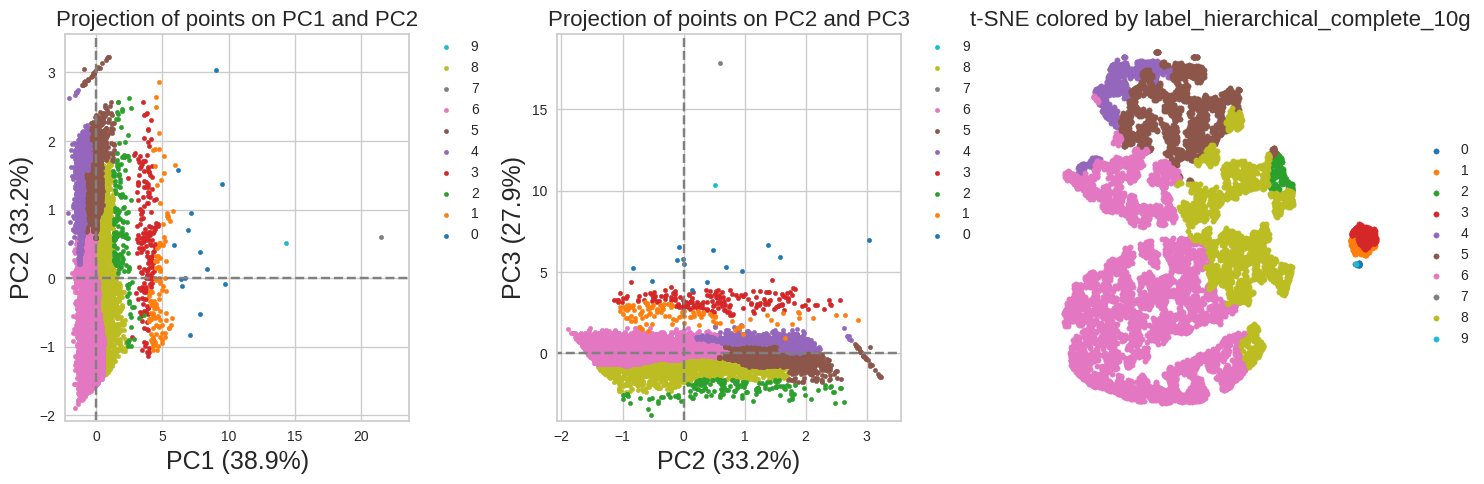

**** label_hierarchical_ward_6g ****


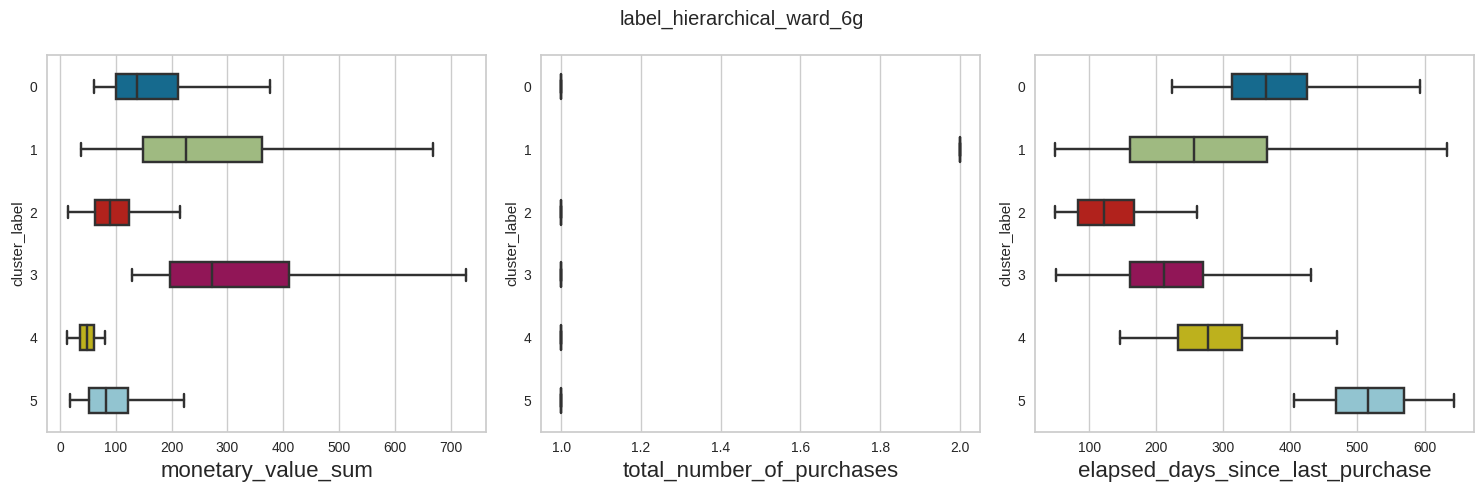

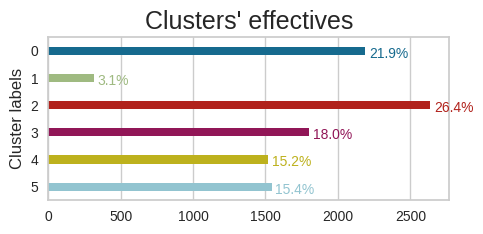

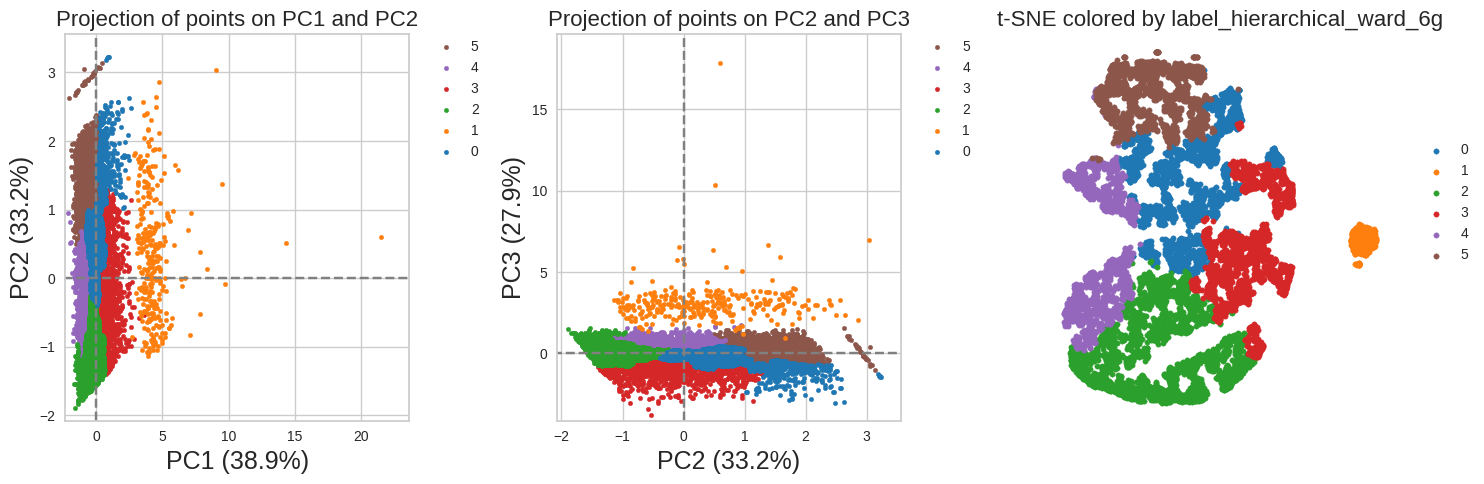

**** label_hierarchical_ward_11g ****


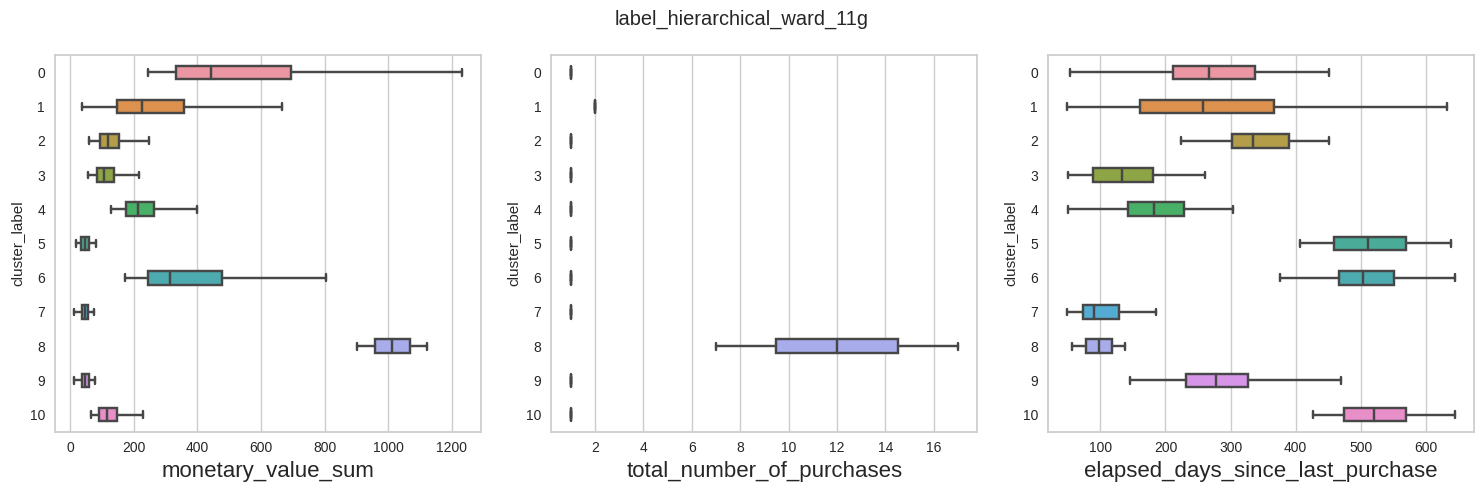

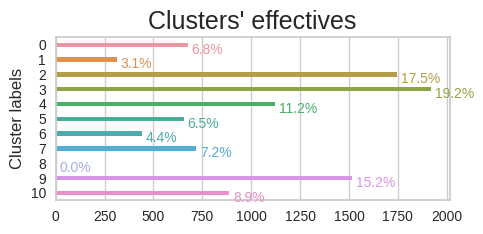

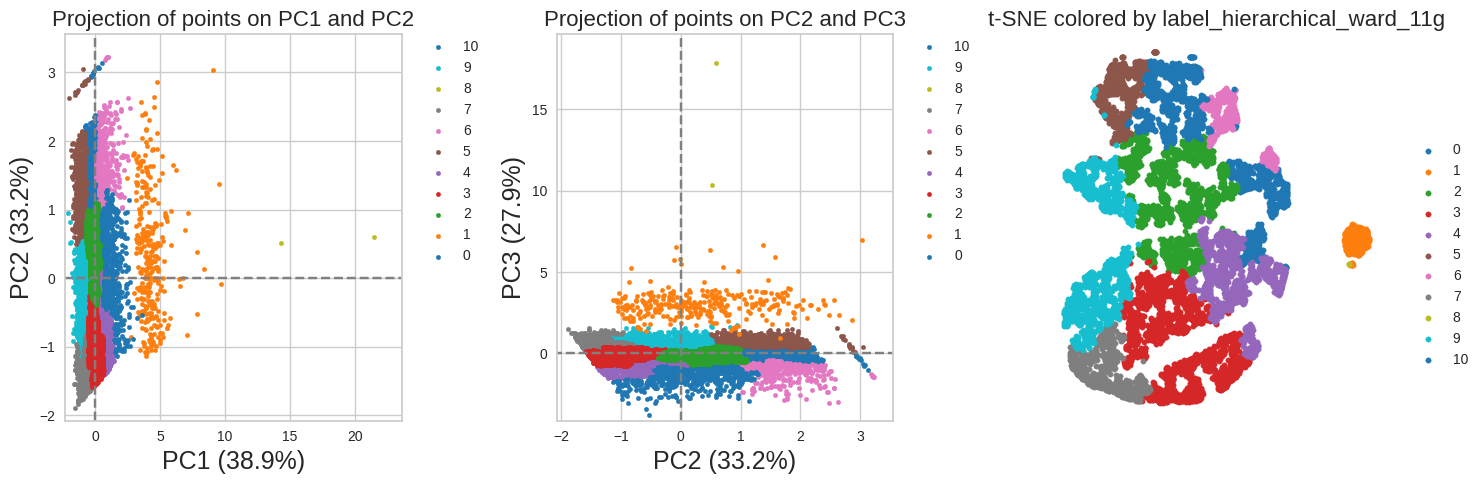

**** label_hierarchical_average_8g ****


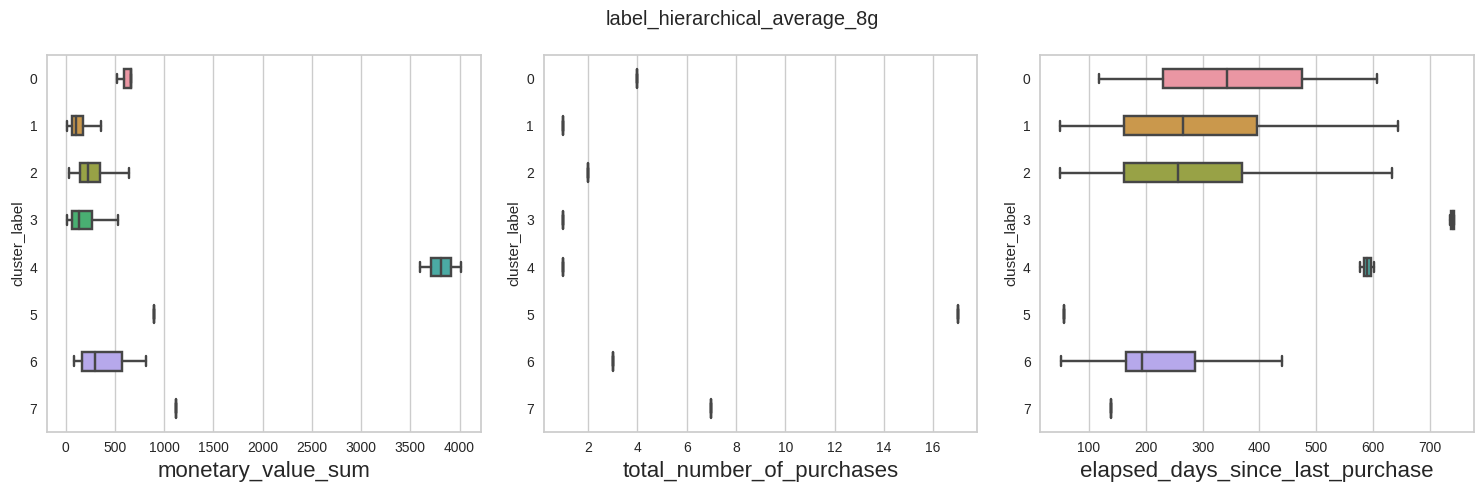

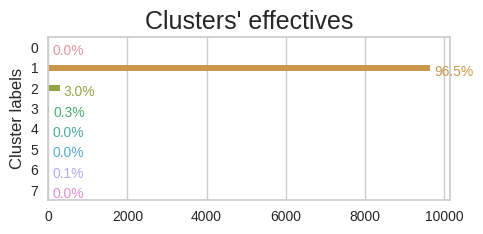

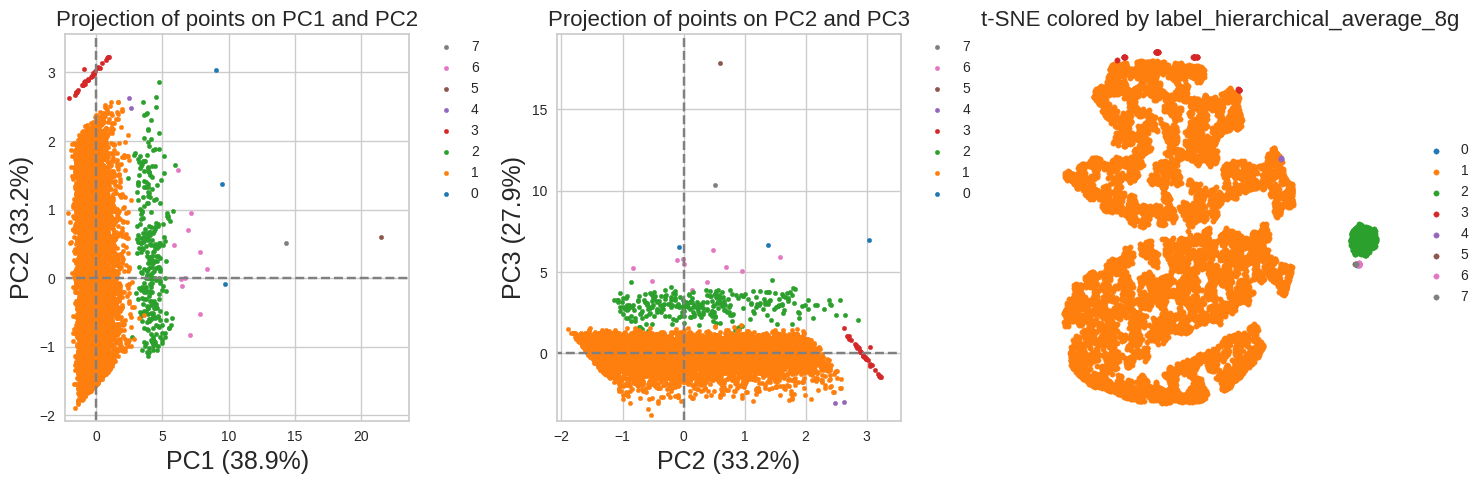

**** label_hierarchical_average_11g ****


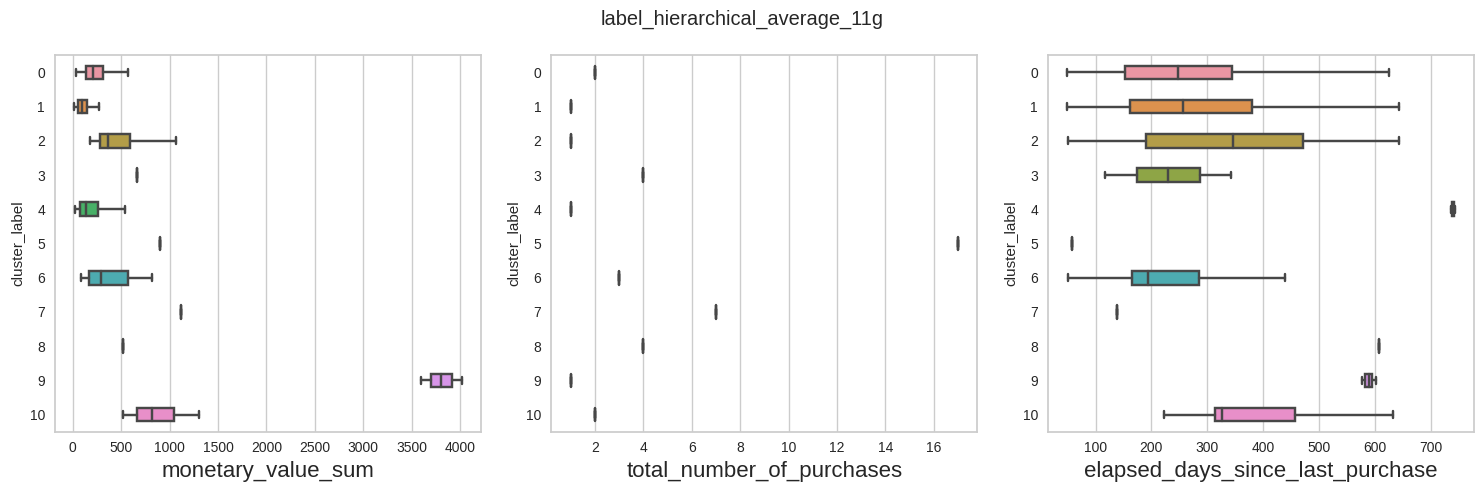

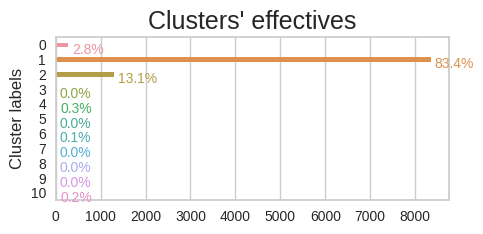

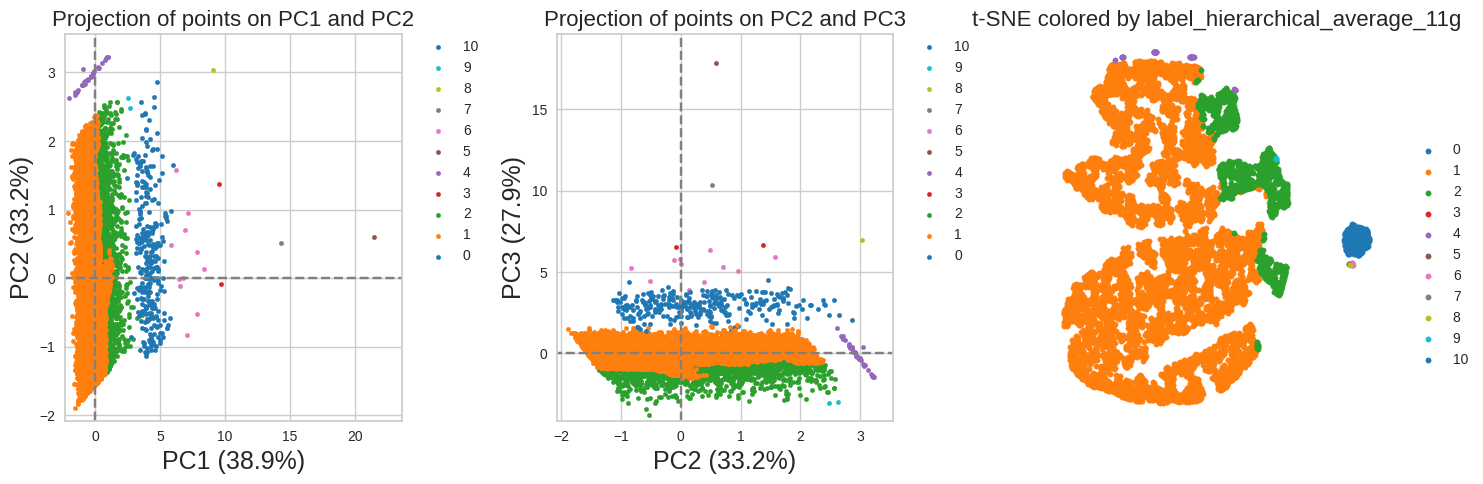

In [6]:
# Clusters content
hierarchical_clustering_labels = ['label_hierarchical_single_6g',
                                  'label_hierarchical_complete_10g', 
                                  'label_hierarchical_ward_6g',
                                  'label_hierarchical_ward_11g',
                                  'label_hierarchical_average_8g',
                                  'label_hierarchical_average_11g']

fts = ['monetary_value_sum',
       'total_number_of_purchases',
       'elapsed_days_since_last_purchase']

for label_name in hierarchical_clustering_labels:
    print(f'**** {label_name} ****')
    label_vec = Xs[label_name]
    ds.display_clusters_comparison(Xs[fts].copy(), label_vec)
    ds.display_clusters_in_pca_space_and_tsne_embedding(
        X_proj, pca, X_tsne, label_vec, label_name,
    )

The hierarchical clustering with the ward-linkage-criterion gives pretty good results in my opinion. 
Especially the ward with 11 groups is convincing. I'll have to explore others cuts later.

For the other criterions, the clusters are more much more imbalanced and the differences it catches first does not seem relevant to me.

## 1.5.  [&#9650;](#toc0_) <a id='toc1_5_'></a>DBSCAN

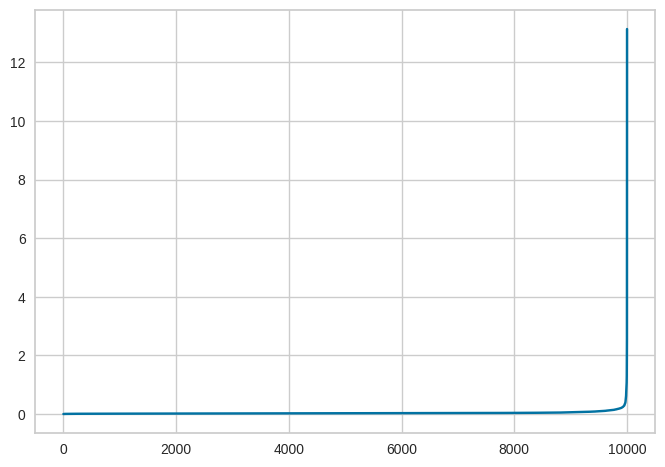

In [24]:
curX = Xspp
# 2*D where D is the number of dimension
min_samples = 2*curX.shape[1]

# Compute and plot ordered average knn distances
# to try and find a knee which is supposed to be the best epsilon.
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(curX)
dists, inds = neighbors.kneighbors(curX)
mean_sorted_distances = np.sort(dists.mean(axis=1))
plt.plot(range(len(mean_sorted_distances)), mean_sorted_distances)
plt.show()

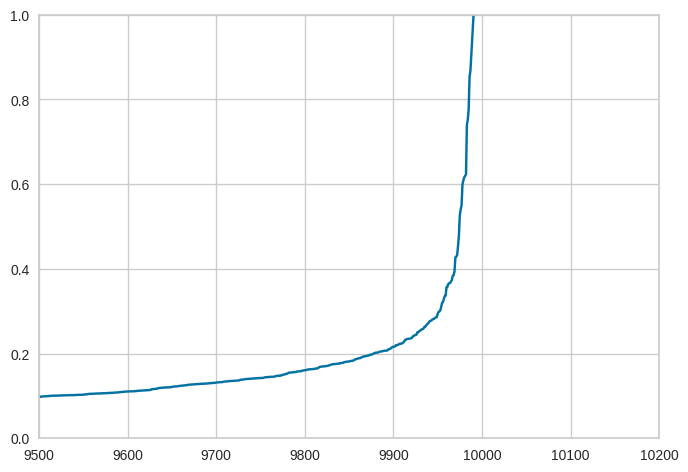

In [25]:
plt.plot(range(len(mean_sorted_distances)), mean_sorted_distances)
plt.axis([9500, 10200, 0, 1])
plt.show()

In [28]:
n_clusters = []
n_noise = []
# Exploring around the knee value for epsilon
epsilons = np.arange(0.2, 0.6, 0.02)
for eps in epsilons:
    print(f'eps : {eps}')
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(curX)
    labels = dbscan.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    n_clusters.append(n_clusters_)
    n_noise.append(n_noise_)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

eps : 0.2
Estimated number of clusters: 18
Estimated number of noise points: 222
eps : 0.22
Estimated number of clusters: 15
Estimated number of noise points: 171
eps : 0.24
Estimated number of clusters: 11
Estimated number of noise points: 140
eps : 0.26
Estimated number of clusters: 12
Estimated number of noise points: 122
eps : 0.27999999999999997
Estimated number of clusters: 7
Estimated number of noise points: 107
eps : 0.29999999999999993
Estimated number of clusters: 7
Estimated number of noise points: 95
eps : 0.31999999999999995
Estimated number of clusters: 5
Estimated number of noise points: 81
eps : 0.33999999999999997
Estimated number of clusters: 4
Estimated number of noise points: 69
eps : 0.35999999999999993
Estimated number of clusters: 3
Estimated number of noise points: 64
eps : 0.3799999999999999
Estimated number of clusters: 3
Estimated number of noise points: 55
eps : 0.3999999999999999
Estimated number of clusters: 3
Estimated number of noise points: 48
eps : 0.4

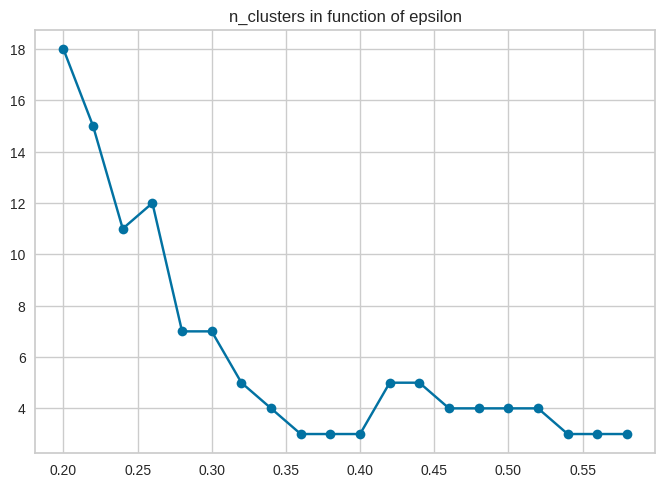

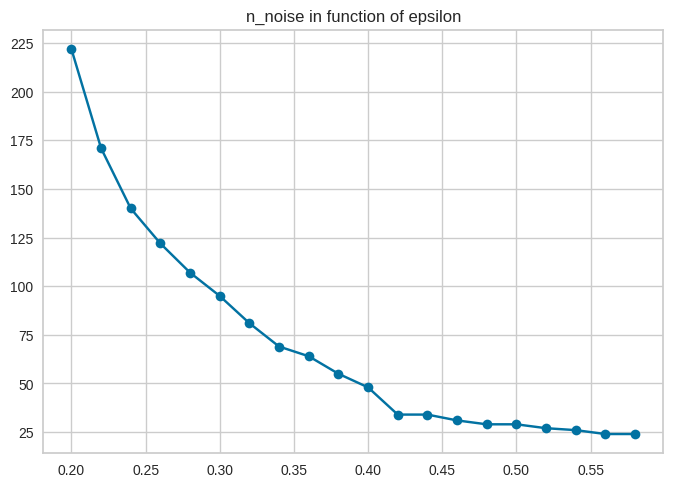

In [29]:
fig, ax = plt.subplots()

for val, label in zip([n_clusters, n_noise], ['n_clusters', 'n_noise']):
    plt.plot(epsilons, val, label=label, marker='o')
    plt.title(f'{label} in function of epsilon')
    plt.show()



In [7]:
# Epsilon 0.42 seems the best here.
dbscan = DBSCAN(min_samples=6, eps=0.42)
dbscan.fit(Xpp)
X['label_dbscan'] = dbscan.labels_

In [31]:
Xs['label_dbscan'] = X.loc[Xs.index, 'label_dbscan']

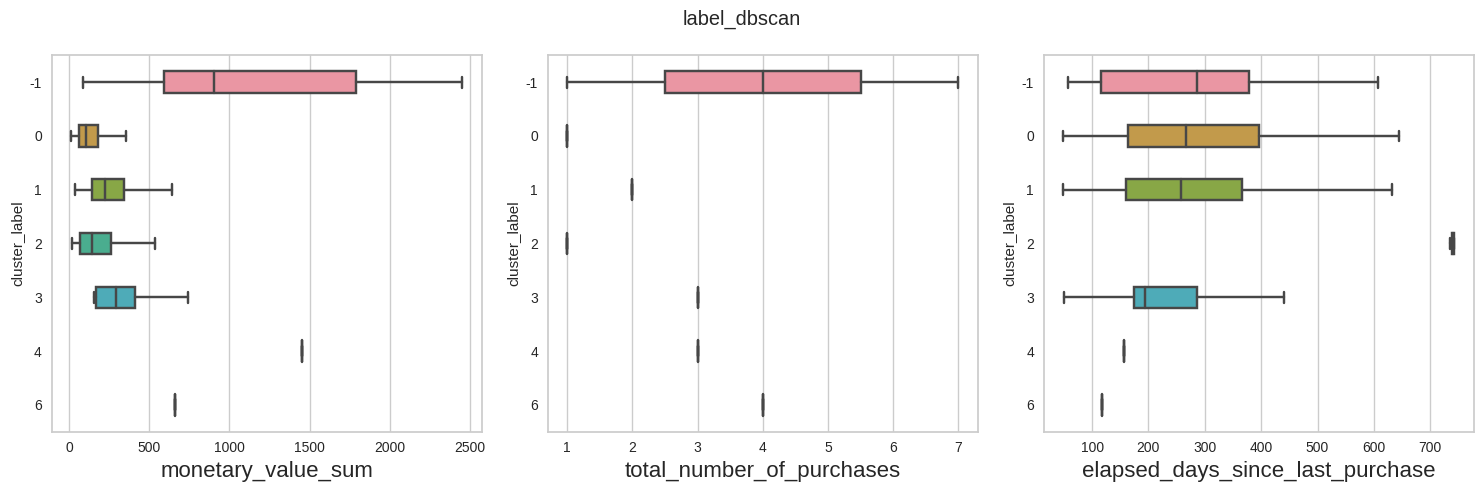

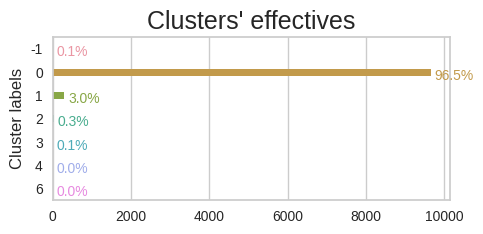

In [32]:
ds.display_clusters_comparison(Xs[fts].copy(), Xs.label_dbscan)

In [ ]:
X.label_dbscan.value_counts() * 100 / len(X)

 0    96.542441
 1     2.858953
 2     0.307221
 3     0.186867
-1     0.082348
 5     0.008446
 6     0.008446
 4     0.005279
Name: label_dbscan, dtype: float64

It also seems that it will give unbalanced clusters. Though, it is not always easy to find to right parameters for min_samples, and epsilon. That's why I'm going to investigate deeper using the OPTICS algorithm.

## 1.6.  [&#9650;](#toc0_) <a id='toc1_6_'></a>OPTICS

In [33]:
clusterer = OPTICS(min_samples=6, xi=0.1, max_eps=0.6)
clusterer.fit(Xspp)

OPTICS(max_eps=0.6, min_samples=6, xi=0.1)

In [41]:
reachability = clusterer.reachability_[clusterer.ordering_]
labels = clusterer.labels_[clusterer.ordering_]
is_multiple_time_buyer = Xs.is_multiple_time_buyer.values[clusterer.ordering_]

reach_df = pd.DataFrame({'reachability': reachability,
                         'is_multiple_time_buyer': is_multiple_time_buyer})
reach_df = reach_df.reset_index(names='order_index')

reach_df.head()

order_index  reachability  is_multiple_time_buyer
0            0           inf                   False
1            1      0.026264                   False
2            2      0.026264                   False
3            3      0.026264                   False
4            4      0.026264                   False

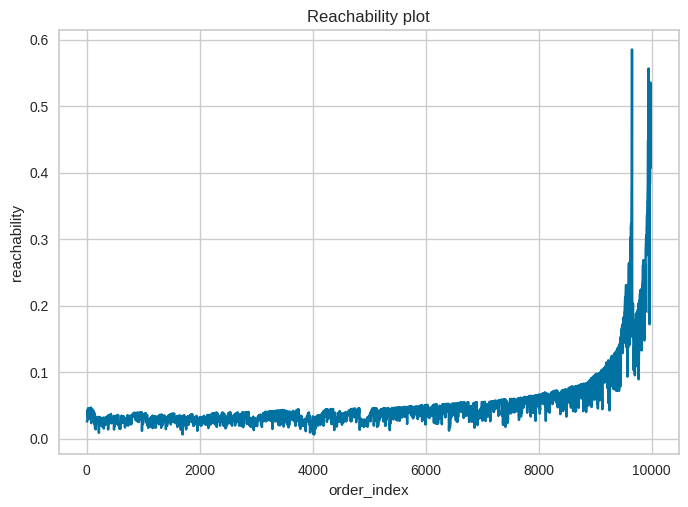

In [42]:
sns.lineplot(data=reach_df, x='order_index', y='reachability')
plt.title('Reachability plot')
plt.show()

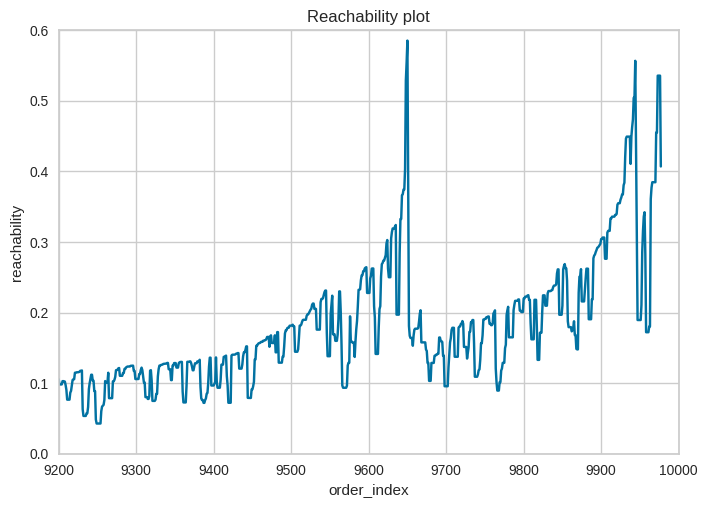

In [43]:
sns.lineplot(data=reach_df, x='order_index', y='reachability')
plt.title('Reachability plot')
plt.axis([9200, 10000, 0, 0.6])
plt.show()

In [44]:
labels.max()

335

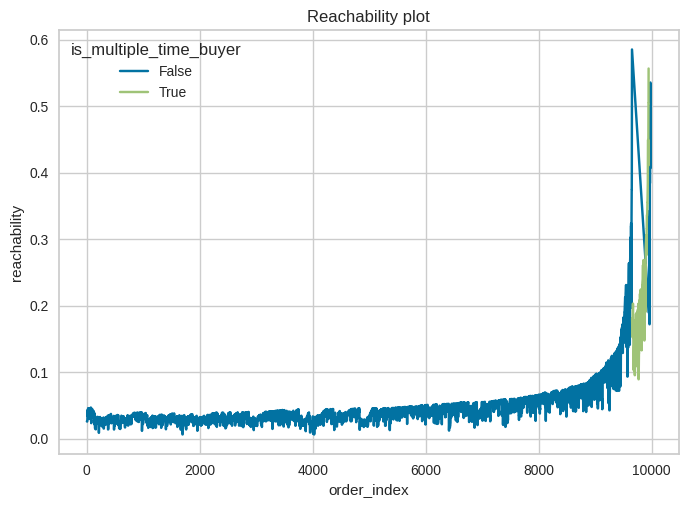

In [45]:
sns.lineplot(data=reach_df, x='order_index', y='reachability',
             hue='is_multiple_time_buyer')
plt.title('Reachability plot')
plt.show()

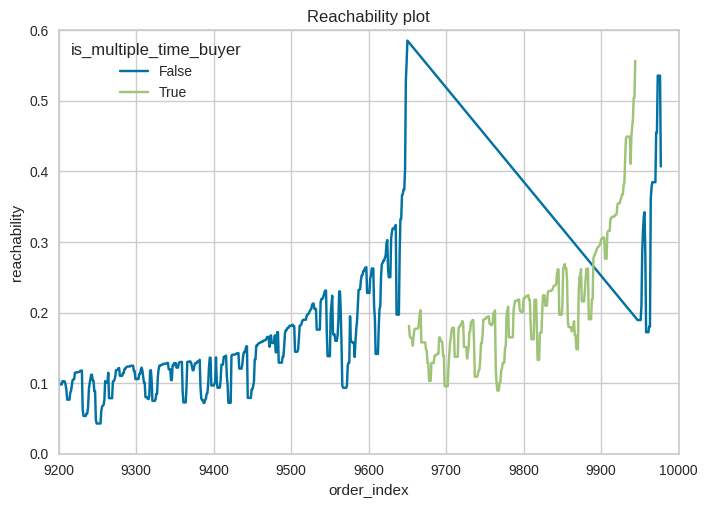

In [46]:
sns.lineplot(data=reach_df, x='order_index', y='reachability',
             hue='is_multiple_time_buyer')
plt.title('Reachability plot')
plt.axis([9200, 10000, 0, 0.6])
plt.show()

The reachability plot shows 3 obvious clusters. 

Those two clusters are again obviously about multiple-time buyers and one-time buyers.

The third (smallest one) is probably the line introduced by the discontinuity of the data in the early dataset (end of 2016) that we can visualize in the first plane of the PCA.

The reachability plots shows that if we want more clusters, the size of clusters will suddenly become dramatically small, and thus, the number of clusters would reach a few hundreds, leading to incapacity of explainability to the marketing board. 

Then, density-based spatial clustering methods are not convenient here. I will not give an easy actionnable clustering.

## 1.7.  [&#9650;](#toc0_) <a id='toc1_7_'></a>Conclusion of the first attempts of clustering.

In order to build an actionnable customers segmentation, a density-based spatial clustering is definitely not adapted.

Among the hierarchical clustering, the ward-linkage_criterion seem to gives the best results in term of clusters balance and interpretability.

K-means also gave interesting results. 

Thus, I need to decide which one to use between both of them.

As adding input features might help the improvement of both, I will first continue the feature engineering and then come back to the second part of this notebook.


# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Clustering with more features.